## 1. Ground truth model
Credits:

- Author: Gabin Rousseau
- Code source: predominantly https://github.com/Schumacher-group/cellcircuits

#### Alternative notebook
This notebook focuses on a known model now faithful to the mathematical definition of the described model inference (division probability determined by a logistic regression term).

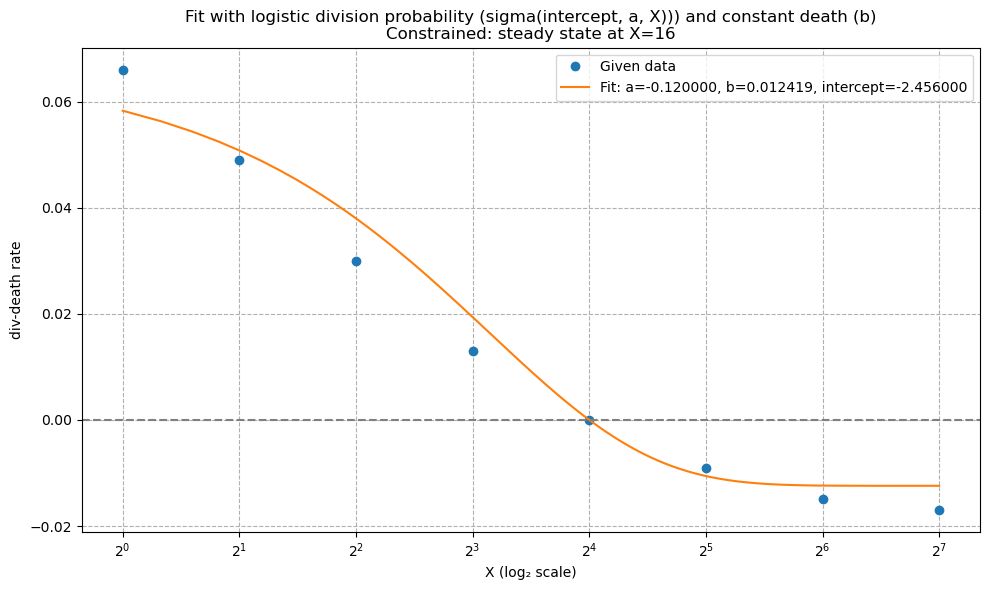

In [5]:
# Re-import necessary libraries after code environment reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Re-define data
X_data = np.array([1, 2, 4, 8, 16, 32, 64, 128])
inner_data = np.array([0.066, 0.049, 0.030, 0.013, 0.00, -0.009, -0.015, -0.017])

# Define the new model with a logistic function
def logistic_decay_model(X, a, b, intercept):
    return  1/(1+np.exp(-(intercept+a*X))) - b #a - b*np.log2(X) #2**-a*X - b #(a*1*(1-X/K) - b*X) #(1 / (1 + np.exp(-a * X)) - b*np.log2(X)) 

# Define residuals for least squares fitting
def residuals(params, X, y):
    a, b, intercept = params
    return np.sum((logistic_decay_model(X, a, b, intercept) - y)**2)

# Constraint: steady state at X=16
def constraint(params):
    a, b, intercept = params
    return 1/(1+np.exp(-(intercept+a*16))) - b #a - b*np.log2(16) #2**(-a*16) - b #(a*1*(1-16/K) - b*16) #1 / (1 + np.exp(-a * 16)) - b*np.log2(16)

# Initial guess and bounds
initial_guess = [0.02, 0.08, -5]
cons = {'type': 'eq', 'fun': constraint}
#bounds = [(-100, 100), (-100, 100), (-100, 100)]
b_bound = 1/(1+np.exp(-(16*(-0.120)-2.456)))
bounds = [(-0.120, -0.120), (b_bound, b_bound), (-2.456, -2.456)]

# Fit model
result = minimize(residuals, initial_guess, args=(X_data, inner_data), constraints=cons, bounds=bounds)
a_fit_logistic, b_fit_logistic, intercept_fit_logistic = result.x

# Generate fitted curve
X_fit_range = np.linspace(min(X_data), max(X_data), 500)
y_fit_logistic = logistic_decay_model(X_fit_range, a_fit_logistic, b_fit_logistic, intercept_fit_logistic)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit_range, y_fit_logistic, '-', label=f'Fit: a={a_fit_logistic:.6f}, b={b_fit_logistic:.6f}, intercept={intercept_fit_logistic:.6f}')
plt.axhline(0, color='gray', linestyle='--')
plt.xscale('log', base=2)
plt.xlabel('X (log₂ scale)')
plt.ylabel('div-death rate')
plt.title('Fit with logistic division probability (sigma(intercept, a, X))) and constant death (b)\nConstrained: steady state at X=16')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
#use approximately close parameters that still ensure a 16 SS. (because )
b_bound = 1/(1+np.exp(-(16*(-0.120)-2.456)))
print(b_bound)

0.012419379732308318


In [ ]:
# constrained variant to ensure the steady state at X=16 (where a=16b)

# Redefine the model with the constraint a = 16 * b => a - bX = b(16 - X)
def constrained_model(X, b):
    return b * (16 - X)

# Fit the constrained model
from scipy.optimize import curve_fit
b_constrained, _ = curve_fit(constrained_model, X_data, inner_data)
a_constrained = 16 * b_constrained[0]

# Generate smooth curve for plotting
X_fit_constrained = np.linspace(1, 130, 500)
inner_fit_constrained = constrained_model(X_fit_constrained, b_constrained[0])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit_constrained, inner_fit_constrained, '-', label=f'Constrained fit: a = {a_constrained:.5f}, b = {b_constrained[0]:.5f}')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('X')
plt.ylabel('a - bX')
plt.title('Constrained Fit with a = 16 * b')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the constrained fit over a log2-scaled x-axis
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit_constrained, inner_fit_constrained, '-', label=f'Constrained fit: a = {a_constrained:.5f}, b = {b_constrained[0]:.5f}')
plt.axhline(0, color='gray', linestyle='--')
plt.xscale('log', base=2)
plt.xlabel('X (log₂ scale)')
plt.ylabel('a - bX')
plt.title('Constrained Fit with a = 16 * b (log₂ X-axis)')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

a_constrained, b_constrained[0] #it seems the ODE will struggle to capture the figure S2H results properly, but still, this gives us an initial direction.

[array([0., 0.]), array([16.,  0.]), array([ 0., 16.]), array([16., 16.])]
Unstable
Unstable
Unstable
Stable


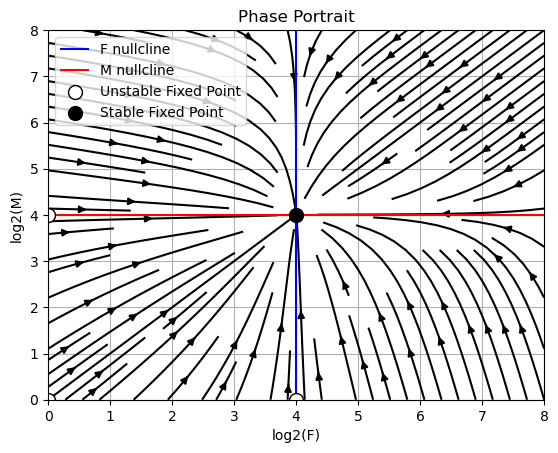

In [1]:
from osdr_validation.phase_portrait_alt import plot_phase_portrait

plot_phase_portrait()

# 2. Simulation of cell distribution data biased by predefined model of division/death

In [4]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [2]:
# parameters
cells=["F","M"] #cell type list

#n=100 #steps for stochastic proliferation

x_boundaries=(0,2500) #tissue size x boundaries in microns
y_boundaries=(0,2500) #tissue size y boundaries in microns

r=80 #neighbourhood radius in microns, same as in Somer et al.

#mF_rates=[0.066,0.049,0.030,0.013,0.00,-0.009,-0.015,-0.017] #division-death rate of mF based on #mF in neighbourhood
#M_rates=[0.066,0.049,0.030,0.013,0.00,-0.009,-0.015,-0.017] #same but with M for #M neibourhood

In [ ]:
# 1. Sample a random initial number of cells for each type (integrated in the next block)
mF_num=round(np.random.uniform(1, 10000))
print(f"Number of mF cells chosen: {mF_num}.")
M_num=round(np.random.uniform(1, 10000))
print(f"Number of M cells chosen: {M_num}.")

Number of mF cells chosen: 8712.
Number of M cells chosen: 5715.


In [5]:
# 2. Sample a random spatial position in the tissue for each cell.


def random_tissue(cells):
    cell_type=[]
    position_x=[]
    position_y=[]
    for cell in cells:
        cell_num=np.random.randint(4400, 4600)
        print(f"Number of {cell} cells chosen: {cell_num}.")
        for i in range(0, cell_num):
            cell_type.append(f"{cell}")
            position_x.append(np.random.uniform(x_boundaries[0],x_boundaries[1]))
            position_y.append(np.random.uniform(y_boundaries[0],y_boundaries[1]))
    tissue=pd.DataFrame(list(zip(cell_type,position_x,position_y)), columns=["Cell_Type","X","Y"])
    
    # Get all spatial coordinates as array for query
    coordinates = tissue[['X', 'Y']].values
    
    for cell in cells:
        # Build KD-Trees for each cell
        tree = cKDTree(tissue[tissue['Cell_Type'] == cell][['X', 'Y']].values)
        #Search neihbourhood contents of the current cell type for all cells
        neighbours = [len(tree.query_ball_point(coords, r)) - (1 if cat == cell else 0)
               for coords, cat in zip(coordinates, tissue['Cell_Type'])]
        column_name=f"#{cell}_neighbours"
        tissue[column_name] = neighbours
        tissue[column_name+"_log2"] = np.log2(neighbours)
        print(np.isneginf(tissue[column_name+"_log2"]).any())
     
    return tissue

tissue=random_tissue(cells)
print(tissue.head())


Number of F cells chosen: 4538.
Number of M cells chosen: 4490.
False
False
  Cell_Type            X            Y  #F_neighbours  #F_neighbours_log2  \
0         F  1806.984709  1266.607920             13            3.700440   
1         F  2446.901263   331.674845             14            3.807355   
2         F   848.759272  1929.103741             17            4.087463   
3         F  1278.974332  2081.699800             15            3.906891   
4         F  2464.044119   281.983776             15            3.906891   

   #M_neighbours  #M_neighbours_log2  
0             13            3.700440  
1             16            4.000000  
2             17            4.087463  
3             14            3.807355  
4             16            4.000000  


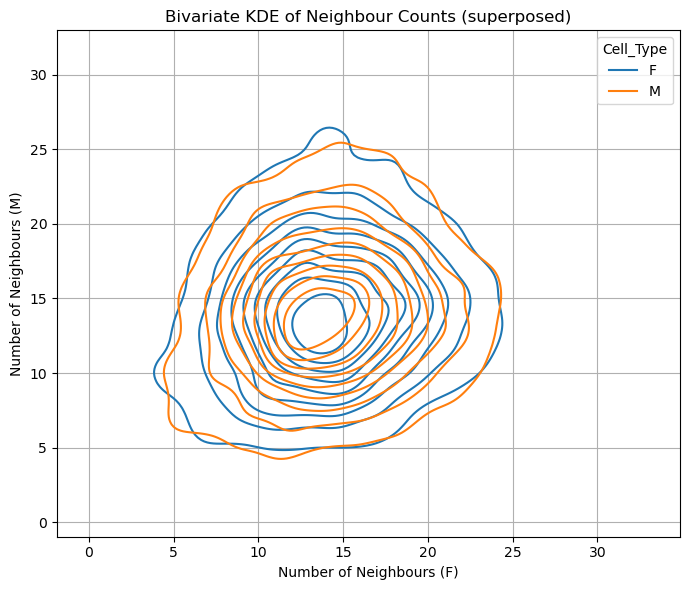

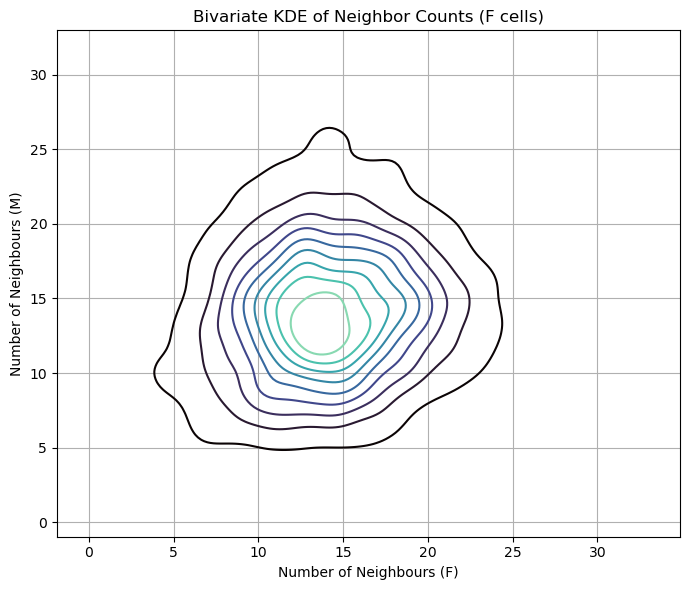

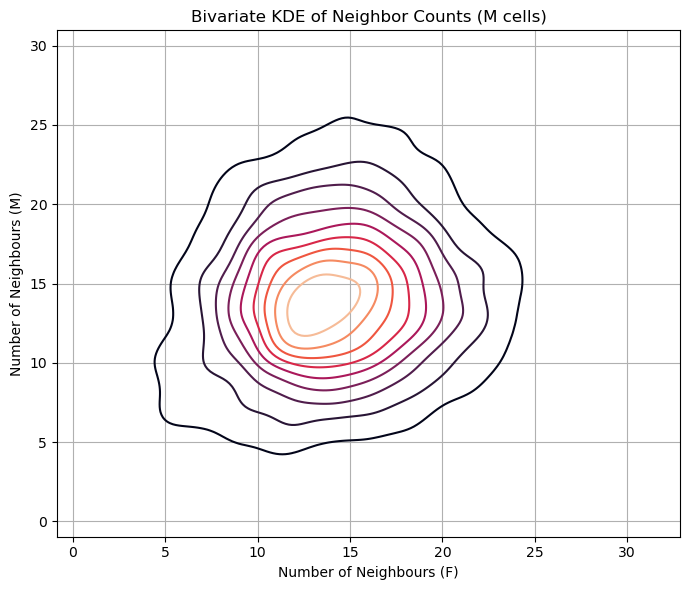

In [6]:
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=tissue,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.xlabel('Number of Neighbours (F)')
plt.ylabel('Number of Neighbours (M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = tissue[tissue['Cell_Type'] == 'F']
df_M = tissue[tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()


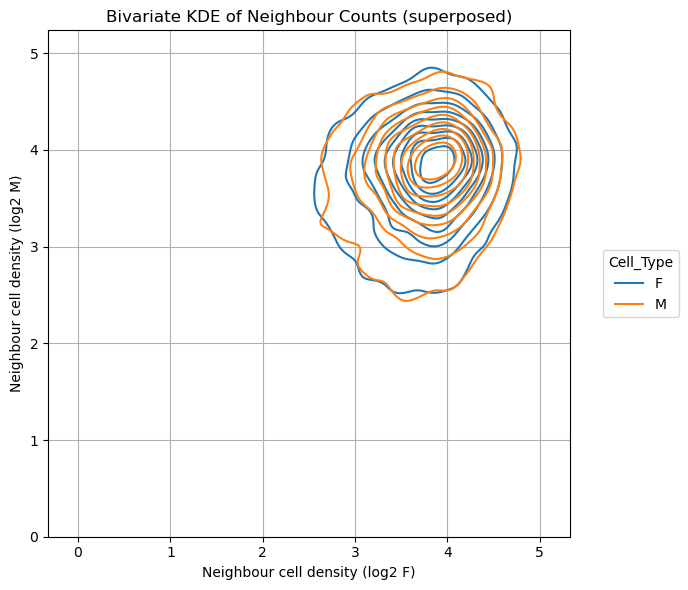

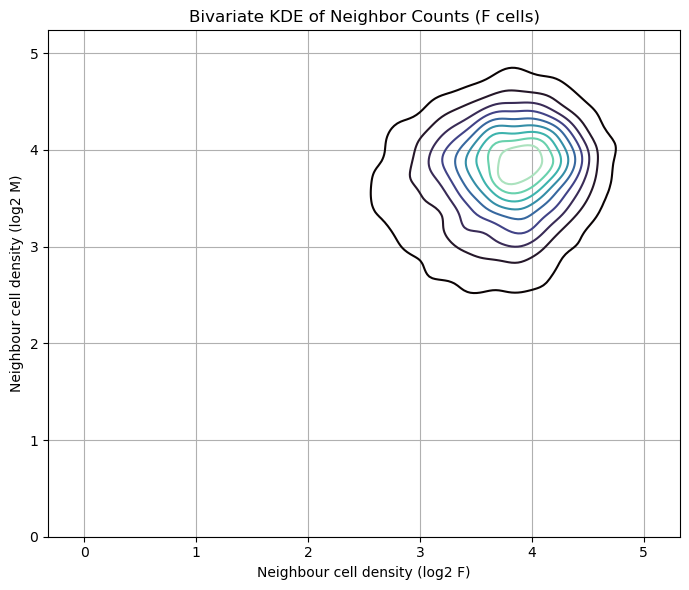

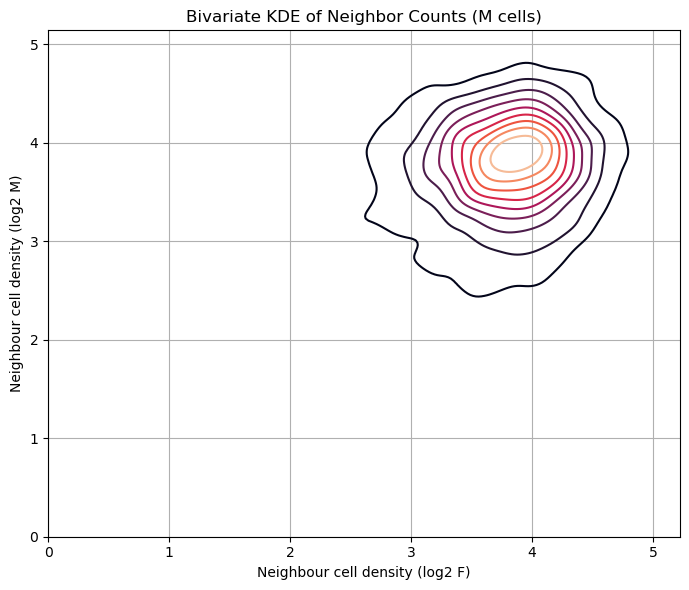

In [7]:
####LOG2 PLOTS####
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
log2_tissue=tissue[np.isfinite(tissue["#F_neighbours_log2"]) & np.isfinite(tissue["#M_neighbours_log2"])]
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=log2_tissue,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.gca().get_legend().set_bbox_to_anchor((1.05, 0.5))
plt.gca().get_legend().set_loc('center left')
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel('Neighbour cell density (log2 F)')
plt.ylabel('Neighbour cell density (log2 M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = log2_tissue[log2_tissue['Cell_Type'] == 'F']
df_M = log2_tissue[log2_tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()


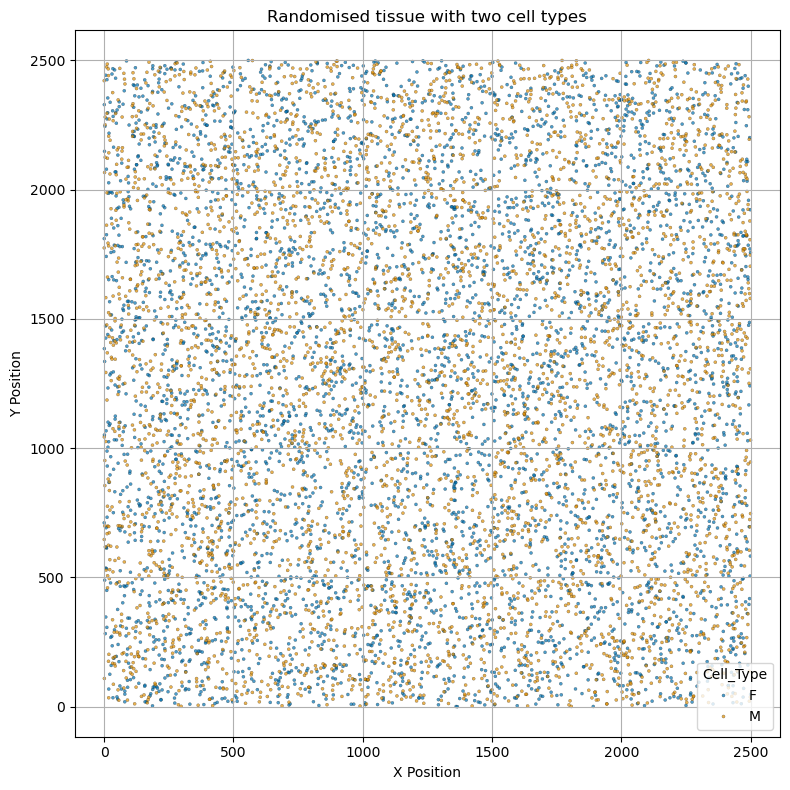

In [8]:
#Show cells of the generated tissue

plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=tissue,
    x='X',
    y='Y',
    hue='Cell_Type',
    palette='colorblind',   
    s=5,             
    edgecolor='black',
    alpha=0.7
)
plt.title("Randomised tissue with two cell types")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

## STOCHASTIC SIM

### NON-PARALLELISED VERSION

In [ ]:
from tqdm import tqdm

#parameters
a, intercept = -0.120, -2.456
b = 1 / (1+np.exp(-(intercept+a*16)))


# 3. stochastic biased proliferation over n steps

def tissue_proliferation(tissue, n=100, t=1): #time value, multiplies the rates
    div_counter=0
    death_counter=0
    stay_counter=0
    for step in tqdm(range(0,n)):
        next_tissue=tissue.copy()
        dead_ids=[]

        for cell_id in range(0,len(tissue)):
            #get current cell
            cell=tissue.iloc[cell_id]

            #get event probabilities
            p_div=F_a*t if cell.iloc[0]=="F" else M_a*t
            p_death=F_b*cell.iloc[3]*t if cell.iloc[0]=="F" else M_b*cell.iloc[5]*t
            p_stay= 1 - p_div - p_death

            if p_stay < 0:
                print("Error with probability space")
                print(p_div)
                print(p_death)
                print(p_stay)
                print(p_div+p_death+p_stay)
                break

            #sample random event uniformly
            r1=np.random.uniform(0,1) #sample event for current cell

            #act on sampled event
            if r1 <= p_div: #division
                rx=np.random.uniform(-r,r)
                ry=np.random.uniform(-r,r)

                #prevent out of bounds and excessive proliferation on the edges
                if cell.iloc[1]+rx < 0 :
                    rx=np.random.uniform(0,r)
                elif cell.iloc[1]+rx > 2500 :
                    rx=np.random.uniform(-r,0)
                if cell.iloc[2]+ry < 0:
                    ry=np.random.uniform(0,r)
                elif cell.iloc[2]+ry > 2500:
                    ry=np.random.uniform(-r,0)
                
                new_cell=[cell.iloc[0],cell.iloc[1]+rx,cell.iloc[2]+ry,2,1,2,1]

                next_tissue.loc[len(next_tissue)]=new_cell
                
                div_counter+=1
            elif r1 <=p_div+p_death: #death
                dead_ids.append(cell_id)
                death_counter+=1
            elif r1<=p_div+p_death+p_stay: #nothing happens
                stay_counter+=1
                pass
            else: #if triggered, I made a mistake in the handling/definition of the events
                print("Unexpected random number.")
                break
        
        #remove chosen dead cells
        next_tissue=next_tissue.drop(dead_ids)
        next_tissue=next_tissue.reset_index(drop=True)

        #recompute neighbours
        coordinates = next_tissue[['X', 'Y']].values
        for type in cells:
            # Build KD-Trees for each cell type
            tree = cKDTree(next_tissue[next_tissue['Cell_Type'] == type][['X', 'Y']].values)
            #Search neihbourhood contents of the current cell type for all cells
            neighbours = [len(tree.query_ball_point(coords, r)) - (1 if cat == type else 0)
                for coords, cat in zip(coordinates, next_tissue['Cell_Type'])]
            column_name=f"#{type}_neighbours"
            next_tissue[column_name] = neighbours
            with np.errstate(divide='ignore', invalid='ignore'): #only log2 of 0 are expected to be compute, leading to -inf values. The log2 plots ignore these so just silence runtime warnings.
                next_tissue[column_name+"_log2"] = np.log2(neighbours)

        tissue=next_tissue.copy()
    print(f"Divisions: {div_counter}\nDeaths: {death_counter}\nStay events: {stay_counter}")
    return tissue



In [ ]:
#num_workers = 4
num_tasks = 10

# Use a random master seed to produce fresh seeds
master_seed = np.random.SeedSequence()  # new every run
child_seeds = master_seed.spawn(num_tasks)
######
rng = np.random.default_rng(1)
# Use rng for random numbers
x = rng.uniform(1, 10)
y=rng.uniform(1, 10)

In [17]:
print(x,y)

5.606394622302311 9.554173266933418


### PARALLELISED VERSION

In [5]:
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
#F parameters
F_a=48*10**-4
F_b=3*10**-4

#M parameters
M_a=48*10**-4
M_b=3*10**-4


# 3. stochastic biased proliferation over n steps

def cell_action(cell_id, t, seed):
            rng = np.random.default_rng(seed)
            global now_tissue
            #get current cell
            cell=now_tissue.iloc[cell_id]

            #get event probabilities
            p_div=F_a*t if cell.iloc[0]=="F" else M_a*t
            p_death=F_b*cell.iloc[3]*t if cell.iloc[0]=="F" else M_b*cell.iloc[5]*t
            p_stay= 1 - p_div - p_death

            if p_stay < 0:
                print("Error with probability space")
                print(p_div)
                print(p_death)
                print(p_stay)
                print(p_div+p_death+p_stay)
                return

            #sample random event uniformly
            r1=rng.uniform(0,1) #sample event for current cell

            #act on sampled event
            if r1 <= p_div: #division
                rx=rng.uniform(-r,r)
                ry=rng.uniform(-r,r)

                #prevent out of bounds and excessive proliferation on the edges
                if cell.iloc[1]+rx < 0 :
                    rx=rng.uniform(0,r)
                elif cell.iloc[1]+rx > 2500 :
                    rx=rng.uniform(-r,0)
                if cell.iloc[2]+ry < 0:
                    ry=rng.uniform(0,r)
                elif cell.iloc[2]+ry > 2500:
                    ry=rng.uniform(-r,0)
                
                new_cell=[cell.iloc[0],cell.iloc[1]+rx,cell.iloc[2]+ry,2,1,2,1]
                return new_cell

                #next_tissue.loc[len(next_tissue)]=new_cell
                
            elif r1 <=p_div+p_death: #death
                #dead_ids.append(cell_id)
                return cell_id
            elif r1<=p_div+p_death+p_stay: #nothing happens
                return None
            else: #if triggered, I made a mistake in the handling/definition of the events
                print("Unexpected random number.")
                return "Error"

def tissue_proliferation(tissue, n=100, t=1): #time value, multiplies the rates
    global now_tissue
    now_tissue=tissue.copy()
    div_counter=0
    death_counter=0
    stay_counter=0
    for step in tqdm(range(0,n)):
        ###prepare controlled random seeding for the parallelised tasks
        num_tasks = len(now_tissue.index)
        # Use a random master seed to produce fresh seeds
        master_seed = np.random.SeedSequence()  # new every run
        child_seeds = master_seed.spawn(num_tasks)
        
        ###safely set the next iteration of the dataframe for edits rather than the current one being looked into
        next_tissue=now_tissue.copy()
        #ids of dead cell row storage
        dead_ids=[]


        #argument list for starmap
        starguments=[(cell_id, t, seed) for cell_id, seed in zip(now_tissue.index, child_seeds)]

        #parallelise cell-specific event sampling and post-process results
        with Pool(processes=cpu_count()) as pool:
            results = pool.starmap(cell_action, starguments)
        for result in results:
            if type(result)==int:
                dead_ids.append(result)
                death_counter+=1
            elif type(result)==list:
                next_tissue.loc[len(next_tissue)]=result
                div_counter+=1
            elif type(result)==type(None):
                stay_counter+=1
            elif result=="Error":
                raise ValueError
            else:
                print("Unexpected starmap result while parsing.")
                print(type(result))
                
        #remove chosen dead cells
        next_tissue=next_tissue.drop(dead_ids)
        next_tissue=next_tissue.reset_index(drop=True)

        #recompute neighbours
        coordinates = next_tissue[['X', 'Y']].values
        for ctype in cells:
            # Build KD-Trees for each cell type
            tree = cKDTree(next_tissue[next_tissue['Cell_Type'] == ctype][['X', 'Y']].values)
            #Search neihbourhood contents of the current cell type for all cells
            neighbours = [len(tree.query_ball_point(coords, r)) - (1 if cat == ctype else 0)
                for coords, cat in zip(coordinates, next_tissue['Cell_Type'])]
            column_name=f"#{ctype}_neighbours"
            next_tissue[column_name] = neighbours
            with np.errstate(divide='ignore', invalid='ignore'): #only log2 of 0 are expected to be compute, leading to -inf values. The log2 plots ignore these so just silence runtime warnings.
                next_tissue[column_name+"_log2"] = np.log2(neighbours)

        now_tissue=next_tissue.copy()
    print(f"Divisions: {div_counter}\nDeaths: {death_counter}\nStay events: {stay_counter}")
    return now_tissue

In [9]:
#Run simulation
proliferated_tissue=tissue_proliferation(tissue, n=200, t=1)
print(proliferated_tissue.head())

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:41<00:00,  1.96it/s]

Divisions: 8819
Deaths: 8037
Stay events: 1838897
  Cell_Type            X            Y  #F_neighbours  #F_neighbours_log2  \
0         F   645.968553  2162.578265              8            3.000000   
1         F  1954.245922   849.235649             17            4.087463   
2         F  2370.135861   663.581874             17            4.087463   
3         F  1814.954640  1706.395494             18            4.169925   
4         F  1615.534851   364.350453             20            4.321928   

   #M_neighbours  #M_neighbours_log2  
0             11            3.459432  
1             17            4.087463  
2             22            4.459432  
3             13            3.700440  
4             11            3.459432  


In [116]:
len(proliferated_tissue)

10316

## PLOTS

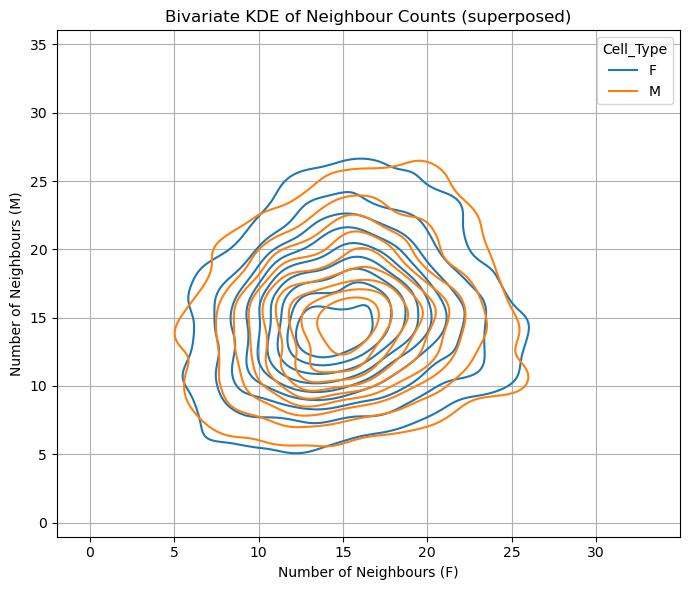

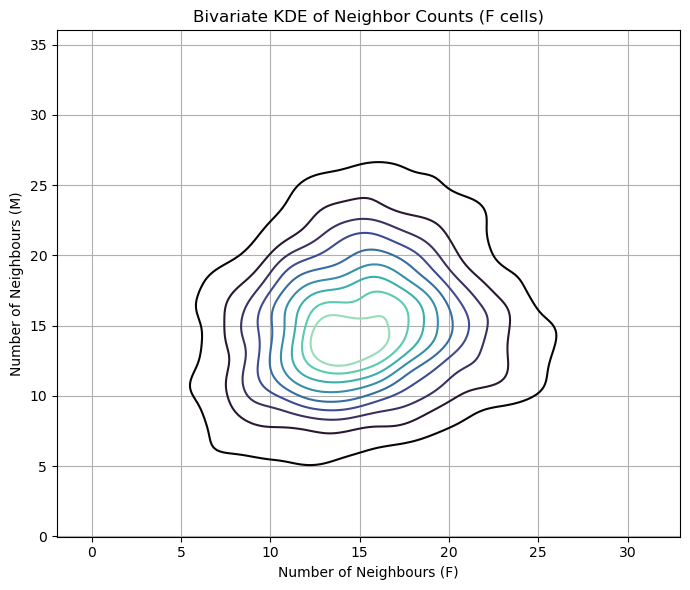

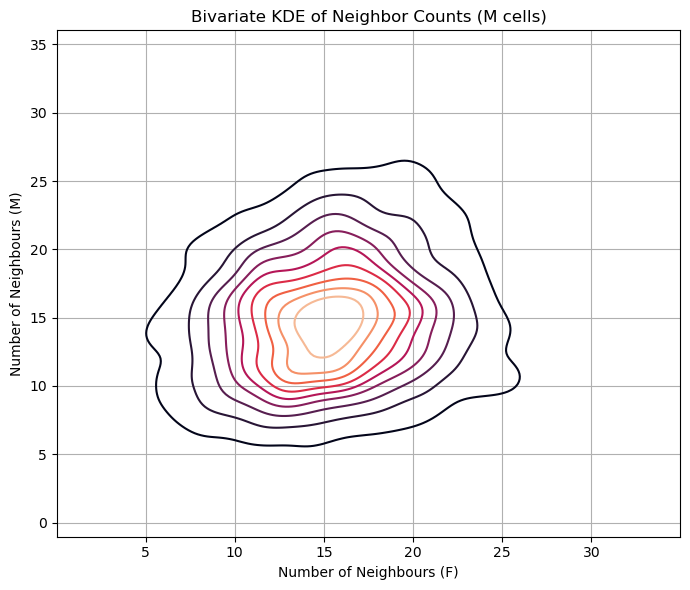

In [10]:
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=proliferated_tissue,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.xlabel('Number of Neighbours (F)')
plt.ylabel('Number of Neighbours (M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = proliferated_tissue[proliferated_tissue['Cell_Type'] == 'F']
df_M = proliferated_tissue[proliferated_tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()


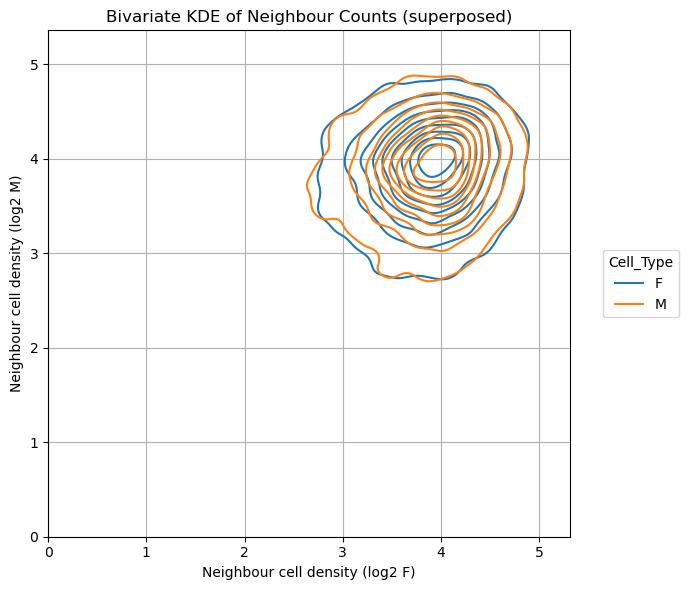

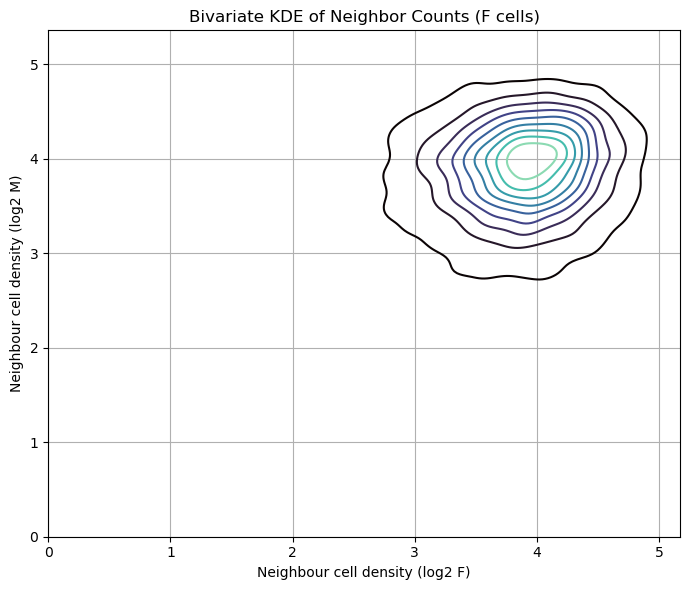

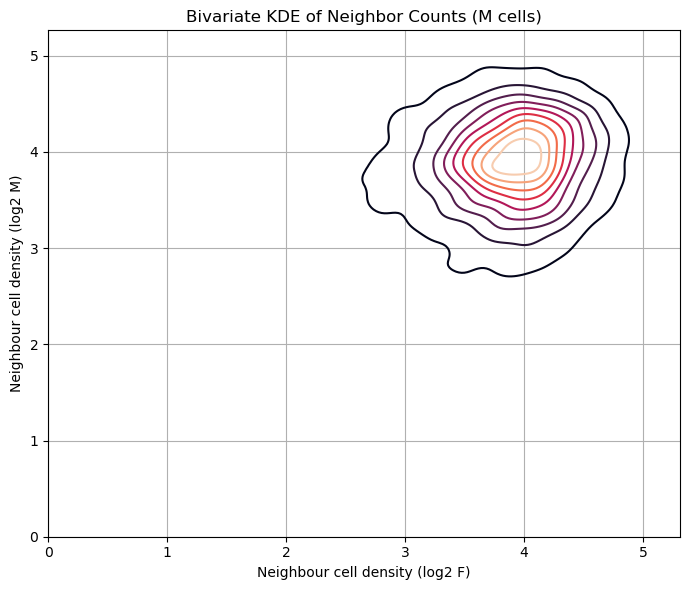

In [8]:
####LOG2 PLOTS####
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
log2_tissue=proliferated_tissue[np.isfinite(proliferated_tissue["#F_neighbours_log2"]) & np.isfinite(proliferated_tissue["#M_neighbours_log2"])]
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=log2_tissue,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.gca().get_legend().set_bbox_to_anchor((1.05, 0.5))
plt.gca().get_legend().set_loc('center left')
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel('Neighbour cell density (log2 F)')
plt.ylabel('Neighbour cell density (log2 M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = log2_tissue[log2_tissue['Cell_Type'] == 'F']
df_M = log2_tissue[log2_tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()


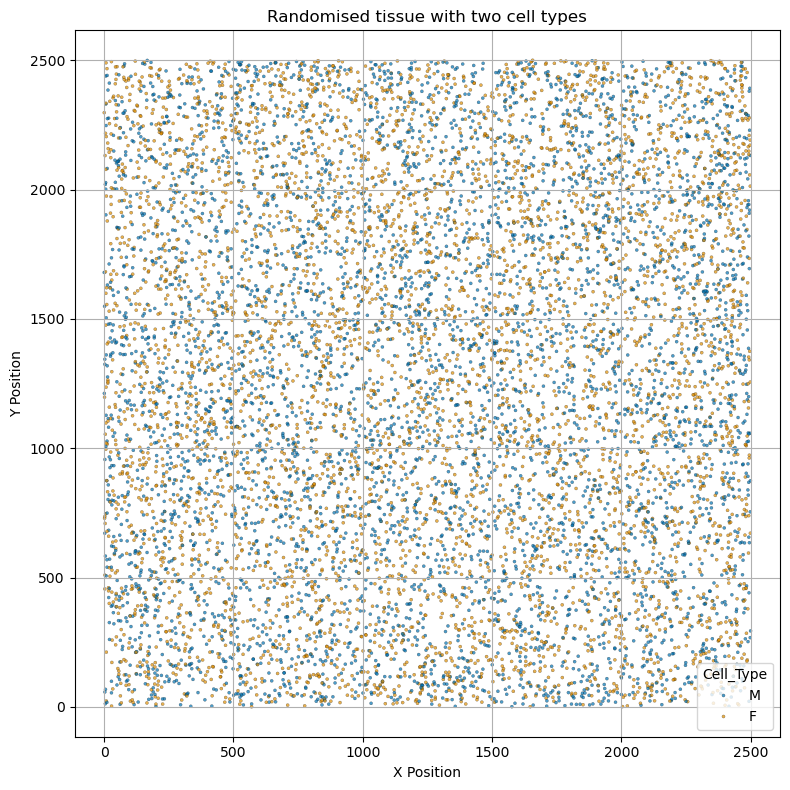

In [139]:
#Show cells of the generated tissue
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=proliferated_tissue,
    x='X',
    y='Y',
    hue='Cell_Type',
    palette='colorblind',   
    s=5,             
    edgecolor='black',
    alpha=0.7
)
plt.title("Randomised tissue with two cell types")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 3. 100-Tissue simulation dataset

In [1]:
#Tissue initiation function

#Note: tissue generation and proliferation are parallelised, so the cell row steps remain unparallelised*

# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from tqdm import tqdm
import time
from multiprocessing import Pool, cpu_count

# global variables
cells=["F","M"] #cell type list

#n=100 #steps for stochastic proliferation

x_boundaries=(0,2500) #tissue size x boundaries in microns
y_boundaries=(0,2500) #tissue size y boundaries in microns

r=80 #neighbourhood radius in microns, same as in Somer et al.

#parameters, the same for both cell types, would require a type-specific parameter set when going for less simple models
a, intercept = -0.120, -2.456
b = 1 / (1+np.exp(-(intercept+a*16)))

#functions
def random_tissue(seed, cells, tissue_id):
    rng = np.random.default_rng(seed)

    idcol=[]
    cell_type=[]
    position_x=[]
    position_y=[]
    
    for cell in cells:
        cell_num=int(rng.integers(250, 9750))
        #print(f"Number of {cell} cells chosen: {cell_num}.")
        for i in range(0, cell_num):
            idcol.append(tissue_id)
            cell_type.append(f"{cell}")
            position_x.append(rng.uniform(x_boundaries[0],x_boundaries[1]))
            position_y.append(rng.uniform(y_boundaries[0],y_boundaries[1]))
    tissue=pd.DataFrame(list(zip(idcol,cell_type,position_x,position_y)), columns=["Tissue_ID","Cell_Type","X","Y"])
    
    # Get all spatial coordinates as array for query
    coordinates = tissue[['X', 'Y']].values
    
    for cell in cells:
        # Build KD-Trees for each cell
        tree = cKDTree(tissue[tissue['Cell_Type'] == cell][['X', 'Y']].values)
        #Search neihbourhood contents of the current cell type for all cells
        neighbours = [len(tree.query_ball_point(coords, r)) - (1 if cat == cell else 0)
               for coords, cat in zip(coordinates, tissue['Cell_Type'])]
        column_name=f"#{cell}_neighbours"
        tissue[column_name] = neighbours
        with np.errstate(divide='ignore', invalid='ignore'):
            tissue[column_name+"_log2"] = np.log2(neighbours)
        #print(np.isneginf(tissue[column_name+"_log2"]).any())
     
    return tissue
def wrapper1(args):
    return random_tissue(*args)

# 3. stochastic biased proliferation over n steps

def tissue_proliferation(seed, tissue, n=100, t=None): 
    if t==None: #if t is not given, only record the final time step
        t=n
    
    rng = np.random.default_rng(seed)

    div_counter=0
    death_counter=0
    stay_counter=0

    t_tracker=0 #when it hits the set t, record data and reset tracker. record final time point no matter what

    proliferation_results=pd.DataFrame(columns=tissue.columns)
    proliferation_results['Time_Step'] = pd.Series(dtype='int')
    
    for step in range(0,n):
        t_tracker+=1

        next_tissue=tissue.copy()
        dead_ids=[]

        for cell_id in range(0,len(tissue)):
            #get current cell
            cell=tissue.iloc[cell_id]

            #get event probabilities
            p_div=1/(1+np.exp(-(intercept+a*cell.iloc[4]))) if cell.iloc[1]=="F" else 1/(1+np.exp(-(intercept+a*cell.iloc[6])))
            p_death=b
            p_stay= 1 - p_div - p_death

            if p_stay < 0:
                print("Error with probability space")
                print(p_div)
                print(p_death)
                print(p_stay)
                print(p_div+p_death+p_stay)
                break

            #sample random event uniformly
            r1=rng.uniform(0,1) #sample event for current cell

            #act on sampled event
            if r1 <= p_div: #division
                rx=rng.uniform(-r,r)
                ry=rng.uniform(-r,r)

                #prevent out of bounds and excessive proliferation on the edges
                if cell.iloc[2]+rx < 0 :
                    rx=rng.uniform(0,r)
                elif cell.iloc[2]+rx > 2500 :
                    rx=rng.uniform(-r,0)
                if cell.iloc[3]+ry < 0:
                    ry=rng.uniform(0,r)
                elif cell.iloc[3]+ry > 2500:
                    ry=rng.uniform(-r,0)
                
                new_cell=[cell.iloc[0],cell.iloc[1],cell.iloc[2]+rx,cell.iloc[3]+ry,2,1,2,1]

                next_tissue.loc[len(next_tissue)]=new_cell
                
                div_counter+=1
            elif r1 <=p_div+p_death: #death
                dead_ids.append(cell_id)
                death_counter+=1
            elif r1<=p_div+p_death+p_stay: #nothing happens
                stay_counter+=1
                pass
            else: #if triggered, I made a mistake in the handling/definition of the events
                print("Unexpected random number.")
                break
        
        #remove chosen dead cells
        next_tissue=next_tissue.drop(dead_ids)
        next_tissue=next_tissue.reset_index(drop=True)

        #recompute neighbours
        coordinates = next_tissue[['X', 'Y']].values
        for ctype in cells:
            # Build KD-Trees for each cell type
            tree = cKDTree(next_tissue[next_tissue['Cell_Type'] == ctype][['X', 'Y']].values)
            #Search neihbourhood contents of the current cell type for all cells
            neighbours = [len(tree.query_ball_point(coords, r)) - (1 if cat == ctype else 0)
                for coords, cat in zip(coordinates, next_tissue['Cell_Type'])]
            column_name=f"#{ctype}_neighbours"
            next_tissue[column_name] = neighbours
            with np.errstate(divide='ignore', invalid='ignore'): #only log2 of 0 are expected to be computed, leading to -inf values. The log2 plots ignore these so just silence runtime warnings.
                next_tissue[column_name+"_log2"] = np.log2(neighbours)

        tissue=next_tissue.copy()

        #record tissue at appropriate time steps
        if step == n-1:
            recorded_tissue=tissue.copy()
            recorded_tissue["Time_Step"]=step+1

            proliferation_results = pd.concat([proliferation_results, recorded_tissue], ignore_index=True)
        elif t_tracker==t:
            recorded_tissue=tissue.copy()
            recorded_tissue["Time_Step"]=step+1

            proliferation_results = pd.concat([proliferation_results, recorded_tissue], ignore_index=True)
            t_tracker=0

    #print(f"Divisions: {div_counter}\nDeaths: {death_counter}\nStay events: {stay_counter}")
    return proliferation_results

def wrapper2(args):
    return tissue_proliferation(*args)

def simulate_model(replicates=100, n=1000, t=100): #t is the time interval to record tissue states for the final dataset
        start_time = time.time()
        ###prepare controlled random seeding for the parallelised tasks
        # Use a random master seed to produce fresh seeds
        master_seed = np.random.SeedSequence()  # new every run
        child_seeds = master_seed.spawn(replicates)
        arguments=[(seed, cells, t_id) for seed, t_id in zip(child_seeds, range(0,100))]
        print("Beginning tissue initialisation...")
        #Initialise random tissues
        with Pool(processes=cpu_count()) as pool:
            results1 = list(tqdm(pool.imap(wrapper1,arguments), total=len(arguments)))
            #results1 = pool.starmap(random_tissue, starguments)
            
        end_time = time.time()
        duration = end_time - start_time
        print(f"Done... This took about {round(duration)} second(s).")
        tissues = pd.concat(results1, ignore_index=True)
        
        #Get a new set of seeds for proliferation
        start_time = time.time()
        master_seed = np.random.SeedSequence()  # new every run
        child_seeds = master_seed.spawn(replicates)
        arguments=[(seed, tissue, n, t) for seed, tissue in zip(child_seeds, results1)]
        print("Beginning tissue proliferation...")
        #Tissue proliferation
        with Pool(processes=cpu_count()) as pool:
            results2 = list(tqdm(pool.imap(wrapper2,arguments), total=len(arguments)))
            #results2 = pool.starmap(tissue_proliferation, starguments)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Done... This took about {round(duration)} second(s).")
        proliferated_tissues = pd.concat(results2, ignore_index=True)

        return tissues, proliferated_tissues

In [10]:
#test proliferation
prolid=tissue_proliferation(0,random_tissue(0, ["F","M"], 0),100,50)

/tmp/ipykernel_279377/1060143209.py:169: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  proliferation_results = pd.concat([proliferation_results, recorded_tissue], ignore_index=True)


In [ ]:
#test again with more recording events to compare time taken
prolid=tissue_proliferation(0,random_tissue(0, ["F","M"], 0),100,20)

/tmp/ipykernel_32342/974145832.py:173: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  proliferation_results = pd.concat([proliferation_results, recorded_tissue], ignore_index=True)


In [11]:
#display test
display(prolid)
print(prolid["Time_Step"].unique())

,Tissue_ID,Cell_Type,X,Y,#F_neighbours,#F_neighbours_log2,#M_neighbours,#M_neighbours_log2,Time_Step
0,0,F,2281.888943,1516.589439,21,4.392317,17,4.087463,50
1,0,F,1823.741402,1359.062479,16,4.000000,15,3.906891,50
2,0,F,6.846250,2143.510691,13,3.700440,10,3.321928,50
3,0,F,1617.973779,1538.462779,14,3.807355,25,4.643856,50
4,0,F,959.193886,2493.024839,10,3.321928,14,3.807355,50
...,...,...,...,...,...,...,...,...,...
23544,0,F,454.556682,2125.614005,18,4.169925,19,4.247928,100
23545,0,F,777.425777,1516.887190,20,4.321928,21,4.392317,100
23546,0,M,603.300569,477.540129,22,4.459432,13,3.700440,100
23547,0,M,128.941911,1076.809259,13,3.700440,16,4.000000,100


[ 50 100]


In [13]:
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### RUN AND SAVE
initial_df, post_df = simulate_model(replicates=100, n=1000, t=100)

# Save df1 to a CSV file
filepath=r'../../data/simulated_tissues_alt.csv'
#initial_df.to_csv(filepath, index=False)
symlink=r'../data/simulated_tissues_alt.csv'
#os.symlink(filepath, symlink)

# Save df2 to a CSV file
filepath_post=r'../../data/simulated_tissues_post_alt.csv'
#post_df.to_csv(filepath_post, index=False)
symlink_post=r'../data/simulated_tissues_post_alt.csv'
#os.symlink(filepath_post, symlink_post)
print("Results saved.")

Beginning tissue initialisation...


100%|██████████| 100/100 [00:02<00:00, 43.92it/s]


Done... This took about 2 second(s).
Beginning tissue proliferation...


100%|██████████| 100/100 [2:00:01<00:00, 72.01s/it]  


Done... This took about 7201 second(s).
Results saved.


In [2]:
#Load from saved dfs, use symbolic links
# Load df1 from CSV
initial_df = pd.read_csv('../data/simulated_tissues.csv')

# Load df2 from CSV
post_df = pd.read_csv('../data/simulated_tissues_post.csv')

In [4]:
#load dataset with time data (one recording of tissues every 100 steps towards an endpoint of t=1000)
# Load t=0 df from CSV
initial_df = pd.read_csv('../data/simulated_tissues2.csv')

# Load t=... from CSV
post_df = pd.read_csv('../data/simulated_tissues_post2.csv')

In [2]:
#load alternative (known model) dataset with time data (one recording of tissues every 100 steps towards an endpoint of t=1000)
# Load t=0 df from CSV
initial_df = pd.read_csv('../data/simulated_tissues_alt.csv')

# Load t=... from CSV
post_df = pd.read_csv('../data/simulated_tissues_post_alt.csv')

In [3]:
print(post_df)

          Tissue_ID Cell_Type            X            Y  #F_neighbours  \
0                 0         F  2062.889011   118.123695             13   
1                 0         F  1384.813417  1875.998273             13   
2                 0         F  1467.652171  1868.006309             14   
3                 0         F  2155.226565   221.643385             15   
4                 0         F  1506.347812   152.392790             20   
...             ...       ...          ...          ...            ...   
10724694         99         F   149.627367   200.271624             14   
10724695         99         F   488.861362  2336.901424             16   
10724696         99         F  2320.521563   645.225325             14   
10724697         99         F    58.011315  1667.436886             20   
10724698         99         F  1381.052146   519.318846             18   

          #F_neighbours_log2  #M_neighbours  #M_neighbours_log2  Time_Step  
0                   3.700440      

## 3.5 - Plot tissue content

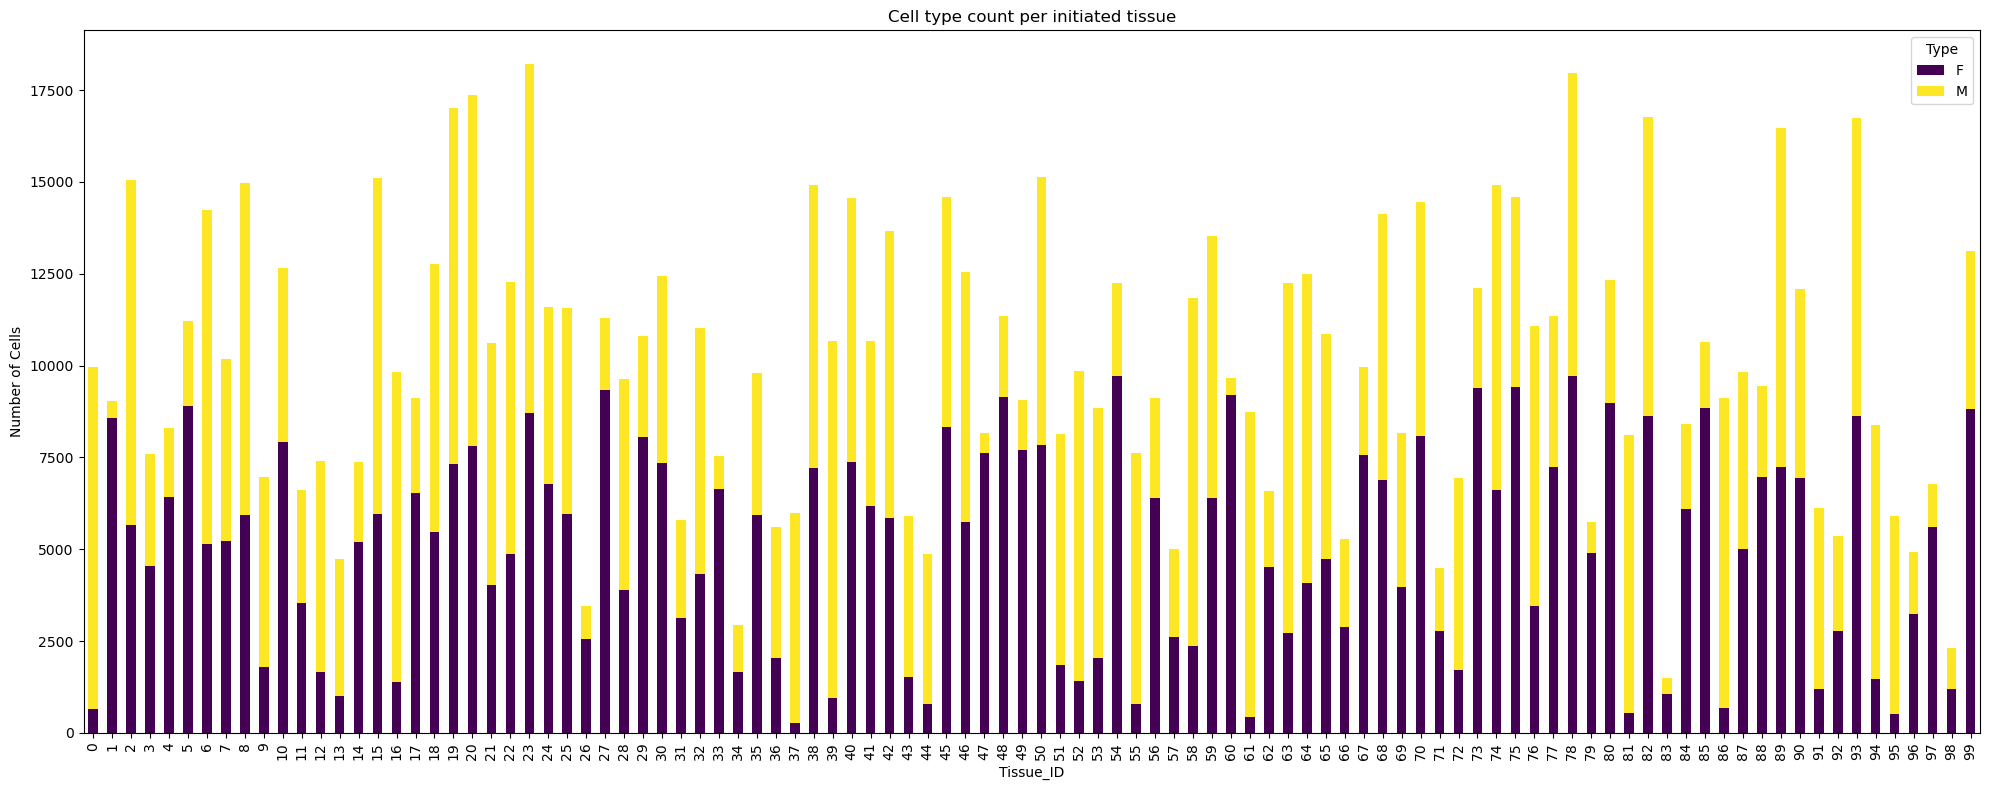

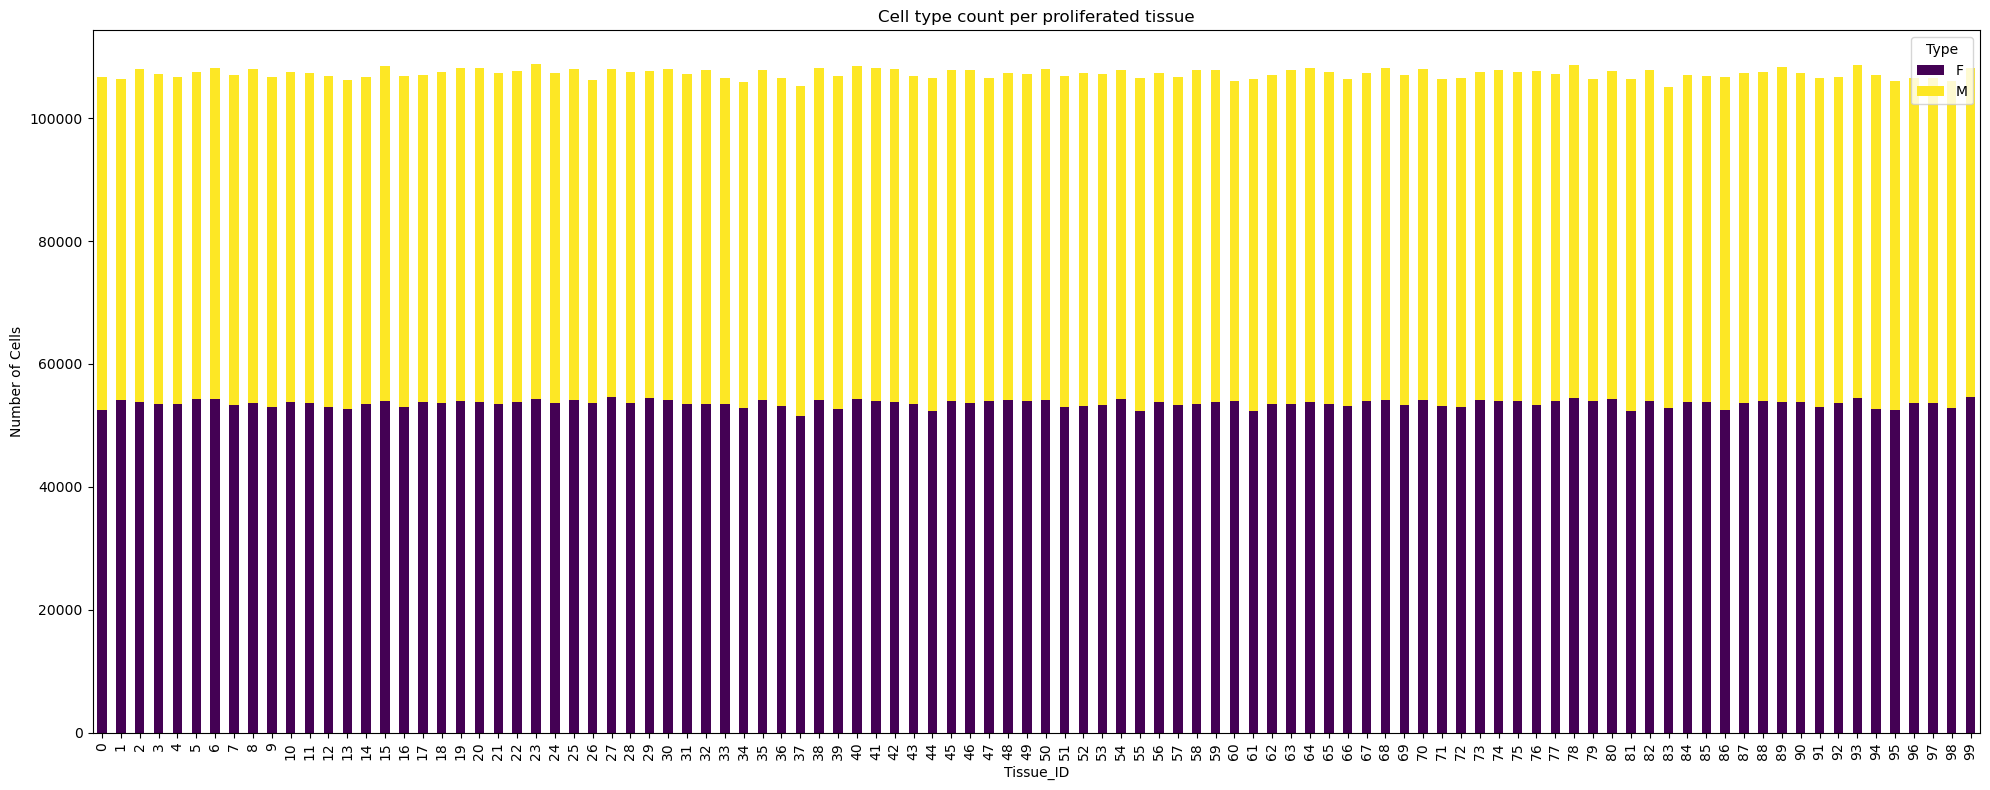

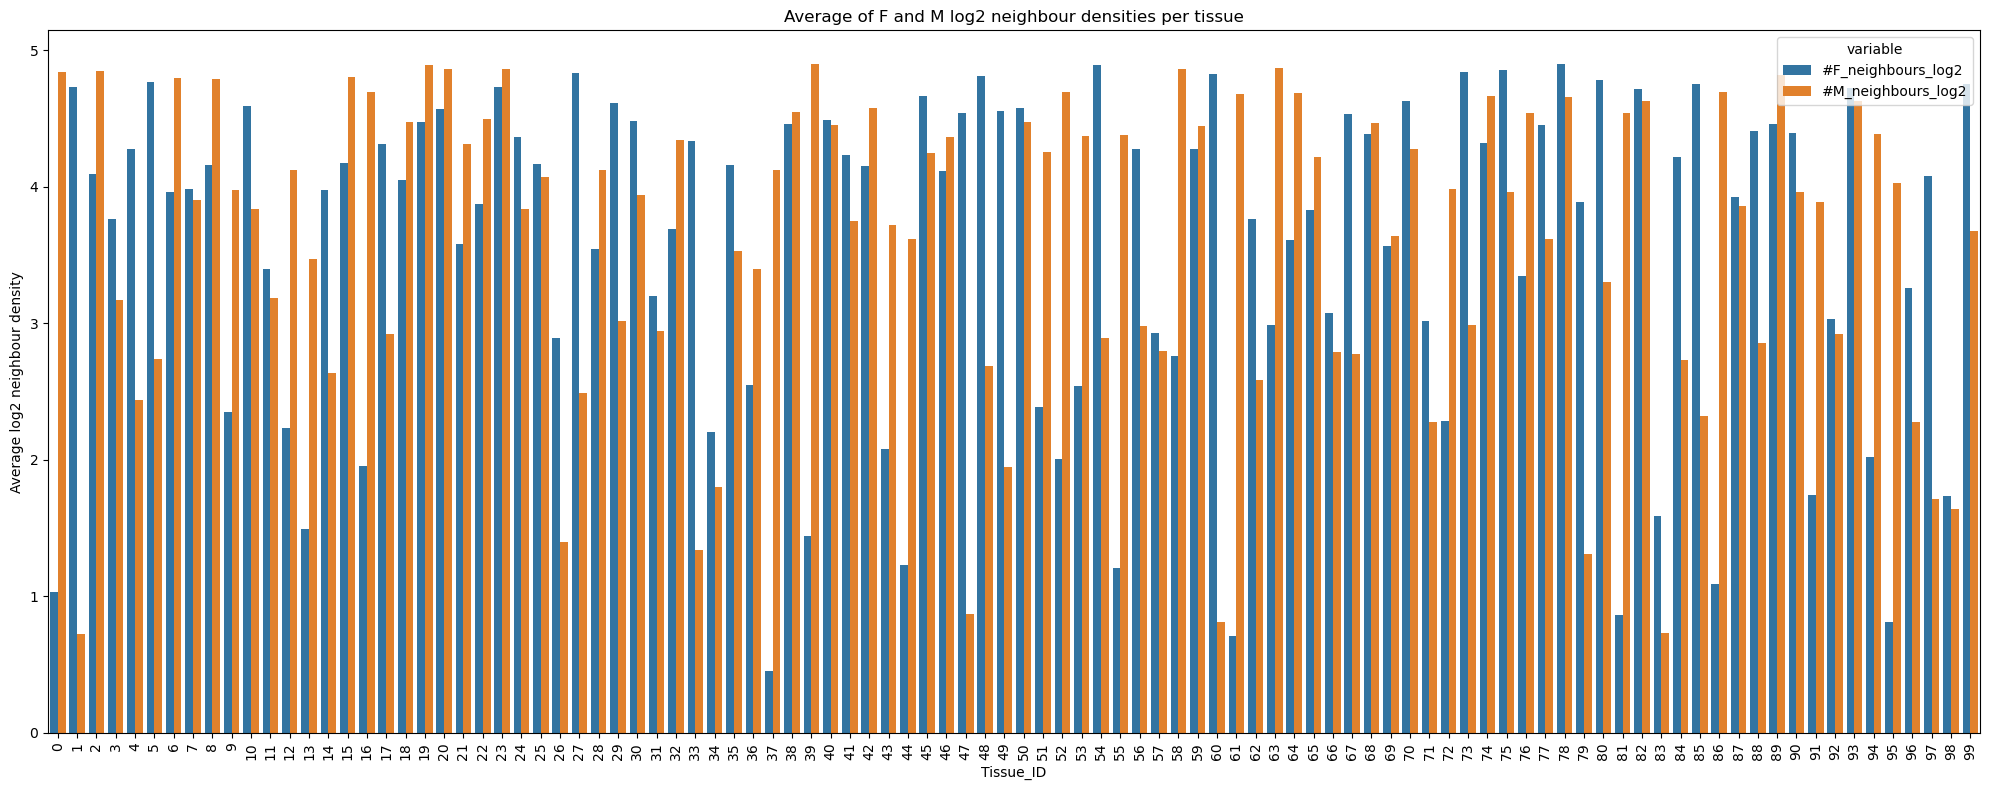

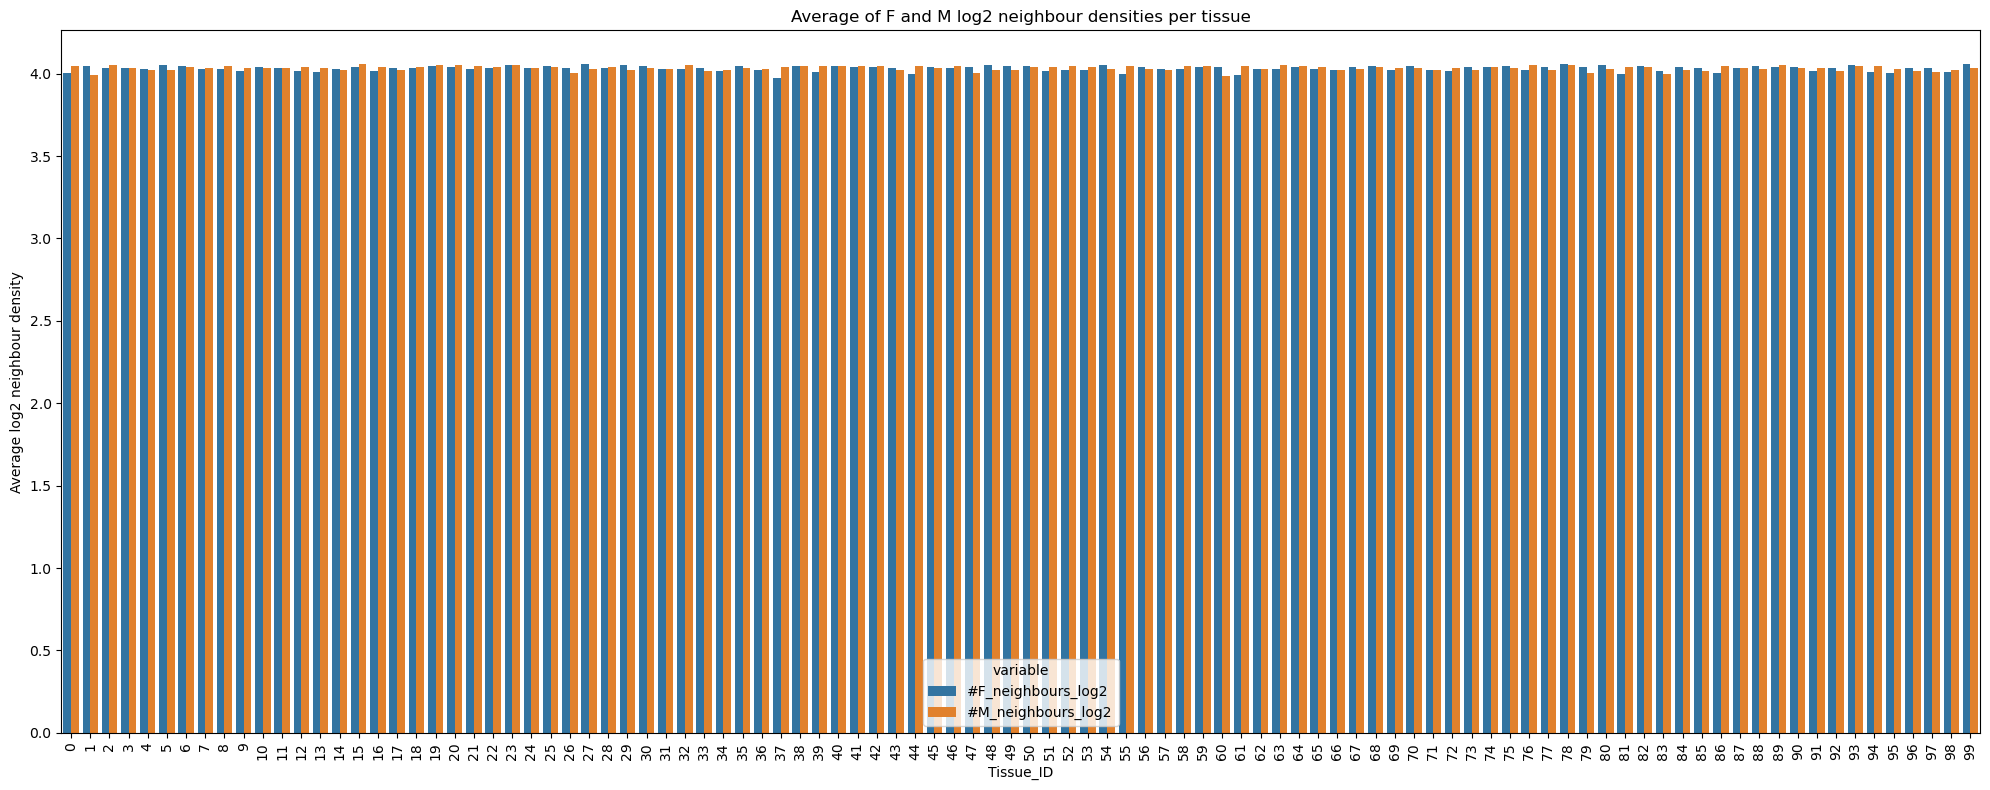

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_average_neighbourhoods(initial_df, post_df):

    # Calculate the count of rows for each category
    count_i_df = pd.crosstab(initial_df['Tissue_ID'], initial_df['Cell_Type'])
    count_p_df = pd.crosstab(post_df['Tissue_ID'], post_df['Cell_Type'])

    #log2 adjustment for dfs
    log2_i_df=initial_df[np.isfinite(initial_df["#F_neighbours_log2"]) & np.isfinite(initial_df["#M_neighbours_log2"])]
    log2_p_df=post_df[np.isfinite(post_df["#F_neighbours_log2"]) & np.isfinite(post_df["#M_neighbours_log2"])]
    # Calculate the average of neighbourhood counts
    average_i_df = log2_i_df.groupby('Tissue_ID')[['#F_neighbours_log2', '#M_neighbours_log2']].mean().reset_index()
    average_p_df = log2_p_df.groupby('Tissue_ID')[['#F_neighbours_log2', '#M_neighbours_log2']].mean().reset_index()
    melted_ai_df = average_i_df.melt(id_vars='Tissue_ID', var_name='variable', value_name='average')
    melted_ap_df = average_p_df.melt(id_vars='Tissue_ID', var_name='variable', value_name='average')

    # Plot count I
    
    count_i_df.plot(kind='bar', stacked=True, figsize=(20, 8), colormap='viridis')

    plt.xlabel('Tissue_ID')
    plt.ylabel('Number of Cells')
    plt.title('Cell type count per initiated tissue')
    #plt.xticks(rotation=90)
    plt.legend(title='Type')
    plt.tight_layout()
    plt.show()

    # Plot count P
    count_p_df.plot(kind='bar', stacked=True,figsize=(20, 8), colormap='viridis')

    plt.xlabel('Tissue_ID')
    plt.ylabel('Number of Cells')
    plt.title('Cell type count per proliferated tissue')
    #plt.xticks(rotation=90)
    plt.legend(title='Type')
    plt.tight_layout()
    plt.show()

    # Plot average I
    plt.figure(figsize=(20, 8))
    sns.barplot(data=melted_ai_df, x='Tissue_ID', y='average', hue='variable')
    plt.xticks(rotation=90)
    plt.xlabel('Tissue_ID')
    plt.ylabel('Average log2 neighbour density')
    plt.title('Average of F and M log2 neighbour densities per tissue')
    plt.tight_layout()
    plt.show()

    # Plot average P
    plt.figure(figsize=(20, 8))
    sns.barplot(data=melted_ap_df, x='Tissue_ID', y='average', hue='variable')
    plt.xticks(rotation=90)
    plt.xlabel('Tissue_ID')
    plt.ylabel('Average log2 neighbour density')
    plt.title('Average of F and M log2 neighbour densities per tissue')
    plt.tight_layout()
    plt.show()

plot_average_neighbourhoods(initial_df, post_df)

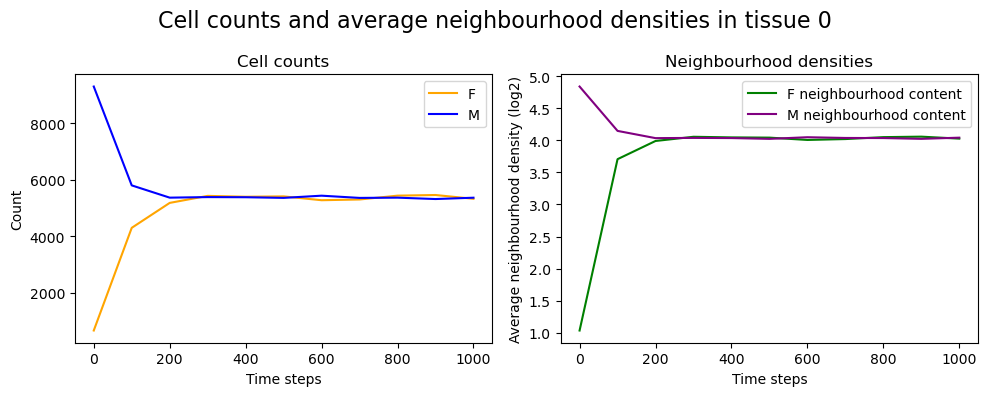

In [34]:

def neighbourhoods_over_time(initial_df, post_df, tissue_id=0):
    #Select tissue from dataframe
    initial_tissue=initial_df.loc[initial_df["Tissue_ID"]==tissue_id].copy()
    post_tissue=post_df.loc[post_df["Tissue_ID"]==tissue_id].copy()

    #log2 adjustment for dfs
    log2_i_df=initial_tissue[np.isfinite(initial_tissue["#F_neighbours_log2"]) & np.isfinite(initial_tissue["#M_neighbours_log2"])]
    log2_p_df=post_tissue[np.isfinite(post_tissue["#F_neighbours_log2"]) & np.isfinite(post_tissue["#M_neighbours_log2"])]

    #x axis container
    time_steps=[0]

    # Containers for counts and neighbourhood averages
    counts_F=[]
    counts_M=[]
    neighmean_F=[]
    neighmean_M=[]
    
    #at t=0
    counts_F.append((initial_tissue["Cell_Type"]=="F").sum())
    counts_M.append((initial_tissue["Cell_Type"]=="M").sum())
    neighmean_F.append((log2_i_df["#F_neighbours_log2"]).mean())
    neighmean_M.append((log2_i_df["#M_neighbours_log2"]).mean())

    #at all time steps
    for step in post_tissue["Time_Step"].unique():
        df=post_tissue.loc[post_tissue["Time_Step"]==step]
        log2_df=log2_p_df.loc[log2_p_df["Time_Step"]==step]

        time_steps.append(step)
        
        counts_F.append((df["Cell_Type"]=="F").sum())
        counts_M.append((df["Cell_Type"]=="M").sum())
        
        neighmean_F.append((log2_df["#F_neighbours_log2"]).mean())
        neighmean_M.append((log2_df["#M_neighbours_log2"]).mean())


    
    #Plots
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Overall cell count
    ax1.plot(time_steps, counts_F, color='orange', linestyle='-', label='F')
    ax1.plot(time_steps, counts_M, color='blue', linestyle='-', label='M')
    ax1.set_title('Cell counts')
    ax1.set_xlabel('Time steps')
    ax1.set_ylabel('Count')
    ax1.legend()

    # Neighbourhood plot
    ax2.plot(time_steps, neighmean_F, color='green', linestyle='-', label='F neighbourhood content')
    ax2.plot(time_steps, neighmean_M, color='purple', linestyle='-', label='M neighbourhood content')
    ax2.set_title('Neighbourhood densities')
    ax2.set_xlabel('Time steps')
    ax2.set_ylabel('Average neighbourhood density (log2)')
    ax2.legend()
 

    # Global title
    fig.suptitle(f'Cell counts and average neighbourhood densities in tissue {tissue_id}', fontsize=16)

    # Display plots
    plt.tight_layout()
    plt.show()
neighbourhoods_over_time(initial_df, post_df, 0)

## 4. Post-proliferation cell sampling

In [3]:
import numpy as np
import pandas as pd

def cell_sampler(post_df, t=None, seed=0):

    #isolate desired time step data
    if t!=None and type(t)==int:
        post_df=post_df.loc[post_df["Time_Step"]==t].copy()
        print(f"\nCell Sampler : Now processing data at t={t}.\n")
    
    #use a seeded number generator
    rng = np.random.default_rng(seed)

    sampled_cells=[]

    #sample with replacement 50k cells evenly across tissues (5k cells/tissue) from the post-proliferation dataset of 100 tissues
    for tissue_id in range(0, 100):
        cell_ids=post_df.index[post_df["Tissue_ID"]==tissue_id].tolist()
        startid=min(cell_ids)
        stopid=max(cell_ids)
        for i in range(0,500):
            sampled_cells.append(int(rng.integers(startid,stopid)))

    main_sample=post_df.loc[sampled_cells].copy() #switch from iloc to loc

    print(f"Done sampling cell data. {len(main_sample)} cells sampled.")

    #make smaller samples from the patchwork cell data (1k cells, 5k, 10k, 25k)
    idrange=range(0,len(main_sample))

    k1_ids=rng.choice(idrange, size=1000, replace=False)
    k5_ids=rng.choice(idrange, size=5000, replace=False)
    k10_ids=rng.choice(idrange, size=10000, replace=False)
    k25_ids=rng.choice(idrange, size=25000, replace=False)
    
    print("Done choosing sampled cells for child dataframes.")
    k1_df=main_sample.iloc[k1_ids].copy()
    print(f"Child 1: {len(k1_df)} cells.")
    #print(k1_df.index.duplicated().sum()) #used to check duplicates
    k5_df=main_sample.iloc[k5_ids].copy()
    print(f"Child 2: {len(k5_df)} cells.")
    k10_df=main_sample.iloc[k10_ids].copy()
    print(f"Child 3: {len(k10_df)} cells.")
    k25_df=main_sample.iloc[k25_ids].copy()
    print(f"Child 4: {len(k25_df)} cells.")
    
    sample_dfs=(main_sample, k1_df, k5_df, k10_df, k25_df)
    print("Done generating child dataframes.")
    return sample_dfs

#main_sample, k1_df, k5_df, k10_df, k25_df  = cell_sampler(post_df)

In [4]:
print(k1_df)

        Tissue_ID Cell_Type            X            Y  #F_neighbours  \
225294         22         M   214.148139   230.572922             16   
534790         52         F  2420.333159  1139.373397             14   
411950         40         F  1584.307652  2461.707160             12   
314845         30         M  2290.075725  1317.149821             11   
981477         96         M  1715.585859   795.909375             11   
...           ...       ...          ...          ...            ...   
589912         57         F  1347.203912   225.984119             14   
566929         55         F    98.982048   342.153613             19   
191801         18         M  1505.576045  1606.127320             16   
249022         24         M  2045.025396   383.315625             17   
201090         19         F    36.906274  1450.636263             13   

        #F_neighbours_log2  #M_neighbours  #M_neighbours_log2  
225294            4.000000             23            4.523562  
534790 

## 5. Model inference with multivariate logistic regression

In [5]:
from sklearn.linear_model import LogisticRegression

#parameters, the same for both cell types, would require a type-specific parameter set when going for less simple models
a, intercept = -0.120, -2.456
b = 1 / (1+np.exp(-(intercept+a*16)))

def tissue_regression(post_df, t=None, seed=0, broadcast=False): #given sampled tissue data, will select from dataset at timepoint t
    rng = np.random.default_rng(seed)

    main_sample, k1_df, k5_df, k10_df, k25_df  = cell_sampler(post_df, t, seed)
    k_dfs=[k1_df, k5_df, k10_df, k25_df]

    #X_dict={}
    if broadcast==True: #if the broadcast argument is given as True, make the y_dict a global variable. This is implemented this way to limit time spent on refactoring the function and others where y_dict would have to be passed around in return/args.
        global y_dict
    y_dict={}
    for i, df in enumerate(k_dfs):
        y_dict[i]=[] #storing sample-specific labels
        for cell_id in range(0,len(df)):
            #current cell
            cell=df.iloc[cell_id]

            #event probabilities
            p_div=1/(1+np.exp(-(intercept+a*cell.iloc[4]))) if cell.iloc[1]=="F" else 1/(1+np.exp(-(intercept+a*cell.iloc[6])))
            p_death=b
            p_stay= 1 - p_div - p_death

            if p_stay < 0:
                print("Error with probability space")
                print(p_div)
                print(p_death)
                print(p_stay)
                print(p_div+p_death+p_stay)
                return
            #sample random event uniformly
            r1=rng.uniform(0,1) #sample event for current cell

            #register sampled event as a binary observation for division
            if r1 <= p_div: #division
                y_dict[i].append(1) #score 1 for binary division observation
            elif r1 <=p_div+p_death: #death
                y_dict[i].append(0) #not division
            elif r1<=p_div+p_death+p_stay: #nothing happens
                y_dict[i].append(0) #still no division
            else: #if triggered, I made a mistake in the handling/definition of the events
                print("Unexpected random number.")
                return
    
    print(f"Completed generation of label y dictionary, with {len(y_dict)} lists stored.")
    print(f"k1 div count: {y_dict[0].count(1)}, p- all ~= {y_dict[0].count(1)/len(y_dict[0])}")
    print(f"k5 div count: {y_dict[1].count(1)}, p- all ~= {y_dict[1].count(1)/len(y_dict[1])}")
    print(f"k10 div count: {y_dict[2].count(1)}, p- all ~= {y_dict[2].count(1)/len(y_dict[2])}")
    print(f"k25 div count: {y_dict[3].count(1)}, p- all ~= {y_dict[3].count(1)/len(y_dict[3])}")
    
    #update dfs with y
    for i, df in enumerate(k_dfs):
        df["Division_Observation"]=y_dict[i]

    #Set parameter dictionaries, one entry per k_df
    pplus_f={}
    pplus_m={}
    pminus_f={}
    pminus_m={}
    print("\n#####INFERENCE#####")

    for i, df in enumerate(k_dfs):
        #fit multivaraite logistic regression model for each cell type given the expected features of each model
        X_f=df[["#F_neighbours"]].loc[df["Cell_Type"]=="F"].copy() #in a broader scenario, all cell types would be used as features, here focus on expectations from known model
        y_f=df["Division_Observation"].loc[df["Cell_Type"]=="F"].copy()
        X_m=df[["#M_neighbours"]].loc[df["Cell_Type"]=="M"].copy()
        y_m=df["Division_Observation"].loc[df["Cell_Type"]=="M"].copy()
    
        model_f=LogisticRegression(random_state=seed).fit(X_f, y_f)
        model_m=LogisticRegression(random_state=seed).fit(X_m, y_m)

        # Get model parameters
        coefficients_f = model_f.coef_
        intercept_f = model_f.intercept_
        coefficients_m = model_m.coef_
        intercept_m = model_m.intercept_

        #Print out some summary values to visualise coefficients and the parameter values inferred.
        print(f"Coefficients of df {i} (F/M):", coefficients_f[0], "/", coefficients_m[0])
        print(f"Intercept of df {i} (F/M):", intercept_f, "/", intercept_m)

        X_testf={"#F_neighbours":[16]}
        X_testf=pd.DataFrame(X_testf)
        z_f=intercept_f + 16*coefficients_f[0][0] # + 16*coefficients_f[0][1]
        p_div_f=1/ (1 + np.exp(-z_f))
        print(f"p+ at known steady state for F, df{i}: {model_f.predict_proba((X_testf))[0][1]}\n...manual computation with logistic function gives: {p_div_f}\n")

        X_testm={"#M_neighbours":[16]}
        X_testm=pd.DataFrame(X_testm)
        z_m=intercept_m + 16*coefficients_m[0][0] # + 16*coefficients_m[0][1]
        p_div_m=1/ (1 + np.exp(-z_m))
        print(f"p+ at known steady state for M, df{i}: {model_m.predict_proba((X_testm))[0][1]}\n...manual computation with logistic function gives: {p_div_m}\n\n")

        #Store parameters
        pplus_f[i]=[intercept_f[0], coefficients_f[0][0]] #for coefficients, i am directly removing the only value from the array, but the aproach would be a bit different if I have more coefs to deal with
        pplus_m[i]=[intercept_m[0], coefficients_m[0][0]]
        pminus_f[i]=y_f.mean()
        pminus_m[i]=y_m.mean()

    print("\n\nReturning parameter dictionaries pplus_f, pplus_m, pminus_f, pminus_m. Each corresponds to the dataset of origin, e.g. 0 for 1K cells sample, 1 for 5k")
    return pplus_f, pplus_m, pminus_f, pminus_m

In [52]:
pplus_f, pplus_m, pminus_f, pminus_m = tissue_regression(post_df)


Done sampling cell data. 50000 cells sampled.
Done choosing sampled cells for child dataframes.
Child 1: 1000 cells.
Child 2: 5000 cells.
Child 3: 10000 cells.
Child 4: 25000 cells.
Done generating child dataframes.
Completed generation of label y dictionary, with 4 lists stored.
k1 div count: 5, p- all ~= 0.005
k5 div count: 29, p- all ~= 0.0058
k10 div count: 41, p- all ~= 0.0041
k25 div count: 123, p- all ~= 0.00492
#####INFERENCE#####
Coefficients of df 0 (F/M): [-0.11207631] / [0.14837961]
Intercept of df 0 (F/M): [-3.46726691] / [-8.06289666]
p+ at known steady state for F, df0: 0.005165945023058515
...manual computation with logistic function gives: [0.00516595]

p+ at known steady state for M, df0: 0.003372163459101643
...manual computation with logistic function gives: [0.00337216]


Coefficients of df 1 (F/M): [0.04572063] / [0.01406073]
Intercept of df 1 (F/M): [-5.92804235] / [-5.3296658]
p+ at known steady state for F, df1: 0.005505361681851227
...manual computation with l

In [53]:
params={"pplus_f":pplus_f, "pplus_m":pplus_m, "pminus_f":pminus_f, "pminus_m":pminus_m}
params


{'pplus_f': {0: [np.float64(-3.467266908111828),
   np.float64(-0.11207631147965431)],
  1: [np.float64(-5.9280423513545975), np.float64(0.04572063206465663)],
  2: [np.float64(-5.170519498574373), np.float64(-0.022318457628441684)],
  3: [np.float64(-4.438358739805286), np.float64(-0.05800585573726159)]},
 'pplus_m': {0: [np.float64(-8.06289666345906),
   np.float64(0.14837961005463707)],
  1: [np.float64(-5.329665802887026), np.float64(0.014060732737178686)],
  2: [np.float64(-4.43771852488877), np.float64(-0.06786052601475415)],
  3: [np.float64(-5.902964896438527), np.float64(0.03788152172329477)]},
 'pminus_f': {0: np.float64(0.005813953488372093),
  1: np.float64(0.005573248407643312),
  2: np.float64(0.0039904229848363925),
  3: np.float64(0.004834031582339671)},
 'pminus_m': {0: np.float64(0.004132231404958678),
  1: np.float64(0.006028938906752411),
  2: np.float64(0.004210104250200481),
  3: np.float64(0.005004766444232603)}}

## 6. Phase portraits of inferred models

In [22]:
#####################################
# PHASE PORTRAIT of INFERRED MODELS #
#####################################
from scipy.optimize import fsolve
#from scipy.integrate import odeint
import autograd.numpy as np
from autograd import jacobian
import matplotlib.pyplot as plt
#######################################
##### OSDR model parameters #####
#######################################

# After the description of the neighbourhood dynamics ODE in Methods, we have
# dX/dt = X(p^+(X) - p^-(X)), with constant division rate parameter p^+(X) = sigma(z), with sigma as the logistic function. z is w0 + w1*X1 + w2*X2..., where w is a model parameter and Xi the number of a cell type i within the neighbourhood radius of a given cell
# ...and death rate parameter p^-, the mean of division observations in the data used to train the inferred model (dividing cells/total cells).

# Steady state: 


pplus_f, pplus_m, pminus_f, pminus_m = tissue_regression(post_df)
params={"pplus_f":pplus_f, "pplus_m":pplus_m, "pminus_f":pminus_f, "pminus_m":pminus_m}

# Define the system of ODEs
def ODE_system(state, params, t_id):
    F, M = state

    #only look at model from 1k sample first
    z_f = params["pplus_f"][t_id][0] + F*params["pplus_f"][t_id][1]
    pp_f = 1/ (1 + np.exp(-z_f))
    pm_f = params["pminus_f"][t_id]

    z_m = params["pplus_m"][t_id][0] + M*params["pplus_m"][t_id][1]
    pp_m = 1/ (1 + np.exp(-z_m))
    pm_m = params["pminus_m"][t_id]

    dF_dt = F * (pp_f - pm_f)
    dM_dt = M * (pp_m - pm_m)
    return [dF_dt, dM_dt]

def ODE_system_np(state, params, t_id):
    F, M = state

    #only look at model from 1k sample first
    z_f = params["pplus_f"][t_id][0] + F*params["pplus_f"][t_id][1]
    pp_f = 1/ (1 + np.exp(-z_f))
    pm_f = params["pminus_f"][0]

    z_m = params["pplus_m"][t_id][0] + M*params["pplus_m"][t_id][1]
    pp_m = 1/ (1 + np.exp(-z_m))
    pm_m = params["pminus_m"][t_id]

    dF_dt = F * (pp_f - pm_f)
    dM_dt = M * (pp_m - pm_m)

    return np.array([dF_dt, dM_dt])


# Generate rates for streamlines adapted to the log2 scale
def streamlines(exp_F, exp_M, params, t_id):
    F = 2**exp_F
    M = 2**exp_M
    dF_dt, dM_dt = ODE_system([F, M], params, t_id)
    return dF_dt, dM_dt




# Plot the phase portrait
def plot_inferred_portrait(params, t_id=0):
    # Parameters for meshgrid
    exp_F_mesh = np.linspace(0, 8, 30)
    exp_M_mesh = np.linspace(0, 8, 30)
    exp_F, exp_M = np.meshgrid(exp_F_mesh, exp_M_mesh)

    # Calculate the growth rates for the streamlines
    F_rate, M_rate = streamlines(exp_F, exp_M, params, t_id)
    F_rate_scaled = F_rate / (2**exp_F)
    M_rate_scaled = M_rate / (2**exp_M)
    
    plt.figure()

    # Streamplot
    plt.streamplot(exp_F, exp_M, F_rate_scaled, M_rate_scaled,
                   color="black")

    # Nullclines
    #F_range, M_range, F_nullcline, M_nullcline = nullclines()
    #plt.plot(np.log2(F_nullcline), np.log2(M_range), 'b-', label='F nullcline')
    #plt.plot(np.log2(F_range), np.log2(M_nullcline), 'r-', label='M nullcline')
    

    # Fixed points
    #fixed_points = find_fixed_points()
    #print(fixed_points)
    # with stability analysis
    

    # Labels and legend
    plt.xlabel('log2(F)')
    plt.ylabel('log2(M)')
    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.legend()
    plt.title('Phase Portrait')
    plt.grid(True)
    plt.show()

Done sampling cell data. 50000 cells sampled.
Done choosing sampled cells for child dataframes.
Child 1: 1000 cells.
Child 2: 5000 cells.
Child 3: 10000 cells.
Child 4: 25000 cells.
Done generating child dataframes.
Completed generation of label y dictionary, with 4 lists stored.
k1 div count: 11, p- all ~= 0.011
k5 div count: 57, p- all ~= 0.0114
k10 div count: 123, p- all ~= 0.0123
k25 div count: 309, p- all ~= 0.01236

#####INFERENCE#####
Coefficients of df 0 (F/M): [-0.02862201] / [-0.19932682]
Intercept of df 0 (F/M): [-3.87671118] / [-1.65088378]
p+ at known steady state for F, df0: 0.012936732263271595
...manual computation with logistic function gives: [0.01293673]

p+ at known steady state for M, df0: 0.007844144264037461
...manual computation with logistic function gives: [0.00784414]


Coefficients of df 1 (F/M): [-0.06198555] / [-0.19570081]
Intercept of df 1 (F/M): [-3.48131901] / [-1.42130504]
p+ at known steady state for F, df1: 0.011283258107234111
...manual computation

In [ ]:
#WIP version

#####################################
# PHASE PORTRAIT of INFERRED MODELS #
#####################################
from scipy.optimize import fsolve
#from scipy.integrate import odeint
import autograd.numpy as np
from autograd import jacobian
import matplotlib.pyplot as plt
#######################################
##### OSDR model parameters #####
#######################################

# After the description of the neighbourhood dynamics ODE in Methods, we have
# dX/dt = X(p^+(X) - p^-(X)), with constant division rate parameter p^+(X) = sigma(z), with sigma as the logistic function. z is w0 + w1*X1 + w2*X2..., where w is a model parameter and Xi the number of a cell type i within the neighbourhood radius of a given cell
# ...and death rate parameter p^-, the mean of division observations in the data used to train the inferred model (dividing cells/total cells).



# Define the system of ODEs
def ODE_system(state, params, t_id):
    F, M = state

    #only look at model from 1k sample first
    z_f = params["pplus_f"][t_id][0] + F*params["pplus_f"][t_id][1]
    pp_f = 1/ (1 + np.exp(-z_f))
    pm_f = params["pminus_f"][t_id]

    z_m = params["pplus_m"][t_id][0] + M*params["pplus_m"][t_id][1]
    pp_m = 1/ (1 + np.exp(-z_m))
    pm_m = params["pminus_m"][t_id]

    dF_dt = F * (pp_f - pm_f)
    dM_dt = M * (pp_m - pm_m)
    return [dF_dt, dM_dt]

def ODE_system_np(args):
    state, params, t_id = args
    F, M = state

    #only look at model from 1k sample first
    z_f = params["pplus_f"][t_id][0] + F*params["pplus_f"][t_id][1]
    pp_f = 1/ (1 + np.exp(-z_f))
    pm_f = params["pminus_f"][0]

    z_m = params["pplus_m"][t_id][0] + M*params["pplus_m"][t_id][1]
    pp_m = 1/ (1 + np.exp(-z_m))
    pm_m = params["pminus_m"][t_id]

    dF_dt = F * (pp_f - pm_f)
    dM_dt = M * (pp_m - pm_m)

    return np.array([dF_dt, dM_dt])


# Generate rates for streamlines adapted to the log2 scale
def streamlines(exp_F, exp_M, params, t_id):
    F = 2**exp_F
    M = 2**exp_M
    dF_dt, dM_dt = ODE_system([F, M], params, t_id)
    return dF_dt, dM_dt

# Define a function to find fixed points for the system from a matrix of points
def find_fixed_points(system, x_range, y_range, num_points, params, t_id): #ranges as tuples with start and end
    # Create a grid of points to test the system
    x_values = np.linspace(x_range[0], x_range[1], num_points)
    y_values = np.linspace(y_range[0], y_range[1], num_points)

    fixed_points = []

    for x in x_values:
        for y in y_values:
            # Use fsolve to find a fixed point
            point = fsolve(system, (x, y), args=(params, t_id))
            # Consider a point a fixed point if the vector field is close to zero
            if np.allclose(system(point, params, t_id), (0, 0), atol=1e-3):
                fixed_points.append(tuple(point))
    
    # Remove duplicates by converting to a set
    unique_fixed_points = list(set(fixed_points))
    return unique_fixed_points

# Calculate stability using the Jacobian
def is_stable(fp, params, t_id):
    jac = jacobian(ODE_system_np)
    J = jac((fp, params, t_id))
    eigenvalues = np.linalg.eigvals(J)
    return all(e.real < 0 for e in eigenvalues)

def is_unstable(fp, params, t_id):
    jac = jacobian(ODE_system_np)
    J = jac((fp, params, t_id))
    eigenvalues = np.linalg.eigvals(J)
    return any(e.real > 0 for e in eigenvalues)

# Plot the phase portrait
def plot_inferred_portrait(params, t_id=0):
    # Parameters for meshgrid
    exp_F_mesh = np.linspace(0, 8, 30)
    exp_M_mesh = np.linspace(0, 8, 30)
    exp_F, exp_M = np.meshgrid(exp_F_mesh, exp_M_mesh)

    # Calculate the growth rates for the streamlines
    F_rate, M_rate = streamlines(exp_F, exp_M, params, t_id)
    F_rate_scaled = F_rate / (2**exp_F)
    M_rate_scaled = M_rate / (2**exp_M)
    
    plt.figure()

    # Streamplot
    plt.streamplot(exp_F, exp_M, F_rate_scaled, M_rate_scaled,
                   color="black")

    # Nullclines
    #F_range, M_range, F_nullcline, M_nullcline = nullclines()
    #plt.plot(np.log2(F_nullcline), np.log2(M_range), 'b-', label='F nullcline')
    #plt.plot(np.log2(F_range), np.log2(M_nullcline), 'r-', label='M nullcline')
    

    # Fixed points
    xrange=(0, 30)
    yrange=(0, 30)

    fixed_points = find_fixed_points(ODE_system, xrange, yrange, 200, params, t_id)
    print(fixed_points)
    # with stability analysis
    label_added = {'Stable': False, 'Unstable': False, 'Semi-stable': False} #point label tracker to avoid redundancy
    for fp in fixed_points:
        x=(np.log2(fp[0])) if fp[0]!=0 else fp[0]
        y=(np.log2(fp[1])) if fp[1]!=0 else fp[1]
        stability=''
        if is_stable(fp, params, t_id):
            stability = 'Stable'
        elif is_unstable(fp, params, t_id):
            stability = 'Unstable'
        else:
            stability = 'Semi-stable'
        print(stability)
        fcolor = 'black' if stability == 'Stable' or stability == 'Semi-stable' else 'white'
        ecolor = 'black' if stability == 'Stable' or stability =='Unstable' else 'red'
        if label_added[stability]==False:
            plt.scatter(x, y, s=100, edgecolors=ecolor, facecolors=fcolor, label=f'{stability} Fixed Point', zorder=2)
            label_added[stability]=True
        else:
            plt.scatter(x, y, s=100, edgecolors=ecolor, facecolors=fcolor, zorder=2)
    

    # Labels and legend
    plt.xlabel('log2(F)')
    plt.ylabel('log2(M)')
    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.legend()
    plt.title('Phase Portrait')
    plt.grid(True)
    plt.show()

In [ ]:
#PLOT FOR one time point (remove t argument if first dataset, which doesn't feature time)
#from osdr_validation.inferred_portraits import plot_inferred_portrait
#alt_params=neg_params(params)


pplus_f, pplus_m, pminus_f, pminus_m = tissue_regression(post_df, t=1000, seed=0)
params={"pplus_f":pplus_f, "pplus_m":pplus_m, "pminus_f":pminus_f, "pminus_m":pminus_m}

for i in range(0,4):
    plot_inferred_portrait(params, t_id=i)

In [ ]:
#PLOT FOR TIME: intervals of 100 until maximum of 1000

for t in post_df["Time_Step"].unique():
    print(f"#####\n Now processing data at t={int(t)}.")

    pplus_f, pplus_m, pminus_f, pminus_m = tissue_regression(post_df, int(t), seed=0)
    params={"pplus_f":pplus_f, "pplus_m":pplus_m, "pminus_f":pminus_f, "pminus_m":pminus_m}

    for i in range(0,4):
        plot_inferred_portrait(params, t_id=i)
    print("#####")

In [ ]:
#PLOT Multiple times (different seeds) for the same timestep in the same dataset
srange=list(range(0,10))

for s in srange:
    print(f"#####\nNow processing data at seed={int(s)}.")

    pplus_f, pplus_m, pminus_f, pminus_m = tissue_regression(post_df, 1000, seed=s)
    params={"pplus_f":pplus_f, "pplus_m":pplus_m, "pminus_f":pminus_f, "pminus_m":pminus_m}

    for i in range(0,4):
        plot_inferred_portrait(params, t_id=i)
    print("#####")

In [50]:
pplus_f, pplus_m, pminus_f, pminus_m = tissue_regression(post_df, t=1000, seed=1)
params={"pplus_f":pplus_f, "pplus_m":pplus_m, "pminus_f":pminus_f, "pminus_m":pminus_m}
print(pplus_f)


Cell Sampler : Now processing data at t=1000.

Done sampling cell data. 50000 cells sampled.
Done choosing sampled cells for child dataframes.
Child 1: 1000 cells.
Child 2: 5000 cells.
Child 3: 10000 cells.
Child 4: 25000 cells.
Done generating child dataframes.
Completed generation of label y dictionary, with 4 lists stored.
k1 div count: 3, p- all ~= 0.003
k5 div count: 21, p- all ~= 0.0042
k10 div count: 48, p- all ~= 0.0048
k25 div count: 120, p- all ~= 0.0048

#####INFERENCE#####
Coefficients of df 0 (F/M): [-0.09611913] / [0.10395975]
Intercept of df 0 (F/M): [-4.08591574] / [-7.95327919]
p+ at known steady state for F, df0: 0.0035978238052385906
...manual computation with logistic function gives: [0.00359782]

p+ at known steady state for M, df0: 0.0018514680200677266
...manual computation with logistic function gives: [0.00185147]


Coefficients of df 1 (F/M): [0.04316078] / [0.05987906]
Intercept of df 1 (F/M): [-6.43139119] / [-6.24515439]
p+ at known steady state for F, df1

In [5]:
#count models that have correct parameter signs (supports monovariate models for now)
def parameter_checker(srange):
    total=0
    gc_dict={0:0,1:0,2:0,3:0}

    for s in srange:
        print(f"Checking seed {s}")
        total+=1
        pplus_f, pplus_m, pminus_f, pminus_m = tissue_regression(post_df, 1000, seed=s)
        for sample in range(0,4):
            if pplus_f[sample][1]<0 and pplus_m[sample][1]<0:
                gc_dict[sample]+=1
    
    freq_good=[round(gc_dict[i]/total,2) for i in gc_dict.keys()]
    print("Checker completed, returning total and frequency of properly signed models per sample size")
    return total, freq_good




In [29]:
#Same thing, but just counting models where we get 2
srange=list(range(0,20))
#srange.append(10)
#srange=srange+list(range(13,19))
#srange.append(21)
#srange.append(24)
#srange=srange+list(range(27, 29))
parameter_checker(srange)

Checking seed 0

Cell Sampler : Now processing data at t=1000.

Done sampling cell data. 50000 cells sampled.
Done choosing sampled cells for child dataframes.
Child 1: 1000 cells.
Child 2: 5000 cells.
Child 3: 10000 cells.
Child 4: 25000 cells.
Done generating child dataframes.
Completed generation of label y dictionary, with 4 lists stored.
k1 div count: 16, p- all ~= 0.016
k5 div count: 63, p- all ~= 0.0126
k10 div count: 116, p- all ~= 0.0116
k25 div count: 316, p- all ~= 0.01264

#####INFERENCE#####
Coefficients of df 0 (F/M): [-0.05729925] / [-0.12250023]
Intercept of df 0 (F/M): [-2.87219219] / [-2.63106539]
p+ at known steady state for F, df0: 0.022118367329339087
...manual computation with logistic function gives: [0.02211837]

p+ at known steady state for M, df0: 0.010040181789095581
...manual computation with logistic function gives: [0.01004018]


Coefficients of df 1 (F/M): [-0.09954525] / [-0.15844737]
Intercept of df 1 (F/M): [-2.80711939] / [-1.8357508]
p+ at known stea

(20, [0.65, 0.95, 1.0, 1.0])

In [17]:
print(post_df)

         Tissue_ID Cell_Type            X            Y  #F_neighbours  \
0                0         F  1397.202632   344.460028              0   
1                0         F  1446.412644  1220.337777              2   
2                0         F  1725.740985  1286.893035              1   
3                0         F  1610.214275   846.272191              4   
4                0         F   383.069894    19.102864              8   
...            ...       ...          ...          ...            ...   
9831520         99         F  1616.294539   894.147790             16   
9831521         99         F  2210.508130   142.295888             11   
9831522         99         F  1840.527943   230.225746             21   
9831523         99         M  2203.411952   788.174766             13   
9831524         99         F  1248.870366  2000.283209              8   

         #F_neighbours_log2  #M_neighbours  #M_neighbours_log2  Time_Step  
0                      -inf             29     

In [12]:
post_df["Time_Step"].unique()

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])

## 7. Visualise fit model against true model over cell neighbourhoods (P+ - P- over Xi).

In [6]:
display(k1_df)

,Tissue_ID,Cell_Type,X,Y,#F_neighbours,#F_neighbours_log2,#M_neighbours,#M_neighbours_log2
225294,22,M,214.148139,230.572922,16,4.000000,23,4.523562
534790,52,F,2420.333159,1139.373397,14,3.807355,23,4.523562
411950,40,F,1584.307652,2461.707160,12,3.584963,9,3.169925
314845,30,M,2290.075725,1317.149821,11,3.459432,12,3.584963
981477,96,M,1715.585859,795.909375,11,3.459432,9,3.169925
...,...,...,...,...,...,...,...,...
589912,57,F,1347.203912,225.984119,14,3.807355,21,4.392317
566929,55,F,98.982048,342.153613,19,4.247928,16,4.000000
191801,18,M,1505.576045,1606.127320,16,4.000000,18,4.169925
249022,24,M,2045.025396,383.315625,17,4.087463,11,3.459432


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt


#parameters, the same for both cell types, would require a type-specific parameter set when going for less simple models
a, intercept = -0.120, -2.456
b = 1 / (1+np.exp(-(intercept+a*16)))

#define functions to get p+ minus p- for a given neighbourhood state (though in the first case, F and M are independent for simplicity, in the infererences)
def div_death_known(state):
    F, M = state

    pp_f = 1/(1+np.exp(-(intercept+a*F)))
    pm_f = b

    pp_m = 1/(1+np.exp(-(intercept+a*M)))
    pm_m = b
    
    return [pp_f-pm_f, pp_m-pm_m]

def div_death_inferred(state, params, t_id):
    F, M = state

    z_f = params["pplus_f"][t_id][0] + F*params["pplus_f"][t_id][1]
    pp_f = 1/ (1 + np.exp(-z_f))
    pm_f = params["pminus_f"][t_id]

    z_m = params["pplus_m"][t_id][0] + M*params["pplus_m"][t_id][1]
    pp_m = 1/ (1 + np.exp(-z_m))
    pm_m = params["pminus_m"][t_id]

    return [pp_f-pm_f, pp_m-pm_m]

#main function to compare fit model to known model points from corresponding sampels
def compare_likelihoods(dfs, params, t_id=0):
    #get the chosen dataframe and separate F and M cell rows
    df=dfs[t_id]
    df_F=df.loc[df["Cell_Type"]=="F"]
    df_M=df.loc[df["Cell_Type"]=="M"]

    #counts of cell X in cell X's neighbourhood
    F_known=[]
    F_infer=[]

    M_known=[]
    M_infer=[]

    #likewise, but p+ minus p-
    divdeath_kf=[]
    divdeath_if=[]

    divdeath_km=[]
    divdeath_im=[]

    #fill known lists, F models then M models
    for i in range(len(df_F)):
        cell=df_F.iloc[i]
        count=int(cell["#F_neighbours"])
        F_known.append(count)
        divdeath_kf.append(div_death_known([count,count])[0])

    for i in range(len(df_M)):
        cell=df_M.iloc[i]
        count=int(cell["#M_neighbours"])
        M_known.append(count)
        divdeath_km.append(div_death_known([count,count])[1])

    #same with lists for inferred data
    for i in range(max(F_known)+10):
        F_infer.append(i)
        divdeath_if.append(div_death_inferred([i,i],params,t_id)[0])
    
    for i in range(max(M_known)+10):
        M_infer.append(i)
        divdeath_im.append(div_death_inferred([i,i],params,t_id)[1])
    
    #plotting 
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # First plot using Seaborn
    #ax1.scatter(F_known, divdeath_kf, color='blue', marker='o', label='Known data')
    ax1.hexbin(F_known, divdeath_kf, gridsize=40, cmap='Blues', mincnt=1, alpha=1)
    ax1.plot(F_infer, divdeath_if, color='orange', linestyle='-', label='Inferred model')
    ax1.set_title('F models')
    ax1.set_xlabel('F')
    ax1.set_ylabel('Proliferation')
    ax1.legend()

    # Second plot using Seaborn
    #ax2.scatter(M_known, divdeath_km, color='green', marker='s', label='Known data')
    ax2.hexbin(M_known, divdeath_km, gridsize=40, cmap='Greens', mincnt=1, alpha=1)
    ax2.plot(M_infer, divdeath_im, color='purple', linestyle='-', label='Inferred model')
    ax2.set_title('M models')
    ax2.set_xlabel('M')
    ax2.set_ylabel('Proliferation')
    ax2.legend()
 

    # Global title
    fig.suptitle(f'Known vs Inference | p+ minus p- | df {t_id}', fontsize=16)

    # Display plots
    plt.tight_layout()
    plt.show()


In [ ]:
#load samples
main_sample, k1_df, k5_df, k10_df, k25_df  = cell_sampler(post_df)
dfs={0:k1_df, 1:k5_df, 2:k10_df, 3:k25_df}

#load inferred parameters
pplus_f, pplus_m, pminus_f, pminus_m = tissue_regression(post_df)
params={"pplus_f":pplus_f, "pplus_m":pplus_m, "pminus_f":pminus_f, "pminus_m":pminus_m}

#first dataset (with only the final tissue state at t=1000)
for i in range(0,4):
    compare_likelihoods(dfs, params, t_id=i)

In [ ]:
#Time data plots
for t in post_df["Time_Step"].unique():
    print(f"t={int(t)}")
    # second dataset, loop through time steps
    #load samples
    main_sample, k1_df, k5_df, k10_df, k25_df  = cell_sampler(post_df, int(t), seed=1)
    dfs={0:k1_df, 1:k5_df, 2:k10_df, 3:k25_df}

    #load inferred parameters
    pplus_f, pplus_m, pminus_f, pminus_m = tissue_regression(post_df, int(t), seed=1)
    params={"pplus_f":pplus_f, "pplus_m":pplus_m, "pminus_f":pminus_f, "pminus_m":pminus_m}

    #first dataset (with only the final tissue state at t=1000)
    for i in range(0,4):
        compare_likelihoods(dfs, params, t_id=i)

## 8. Visualise Logistic Fits

In [61]:
###### Visualising logistic fits

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


#parameters, the same for both cell types, would require a type-specific parameter set when going for less simple models
a, intercept = -0.120, -2.456
b = 1 / (1+np.exp(-(intercept+a*16)))

#define functions to get p+ minus p- for a given neighbourhood state (though in the first case, F and M are independent for simplicity, in the infererences)

def logistic_p(type, count, params, t_id):

    z = params[f"pplus_{type}"][t_id][0] + count*params[f"pplus_{type}"][t_id][1]
    pp = 1/ (1 + np.exp(-z))

    return pp

#main function to compare fit model to known model points from corresponding sampels
def visualise_logfit(dfs, params, t_id=0):
    #get the chosen dataframe and separate F and M cell rows
    df=dfs[t_id].copy()
    df["Division_Observation"]=y_dict[t_id]
    
    df_F=df.loc[df["Cell_Type"]=="F"].copy()

    df_M=df.loc[df["Cell_Type"]=="M"].copy()

    #Prepare data points for logistic plots
    range_f=np.linspace(min(df_F['#F_neighbours']), max(df_F['#F_neighbours']), 200)
    range_m=np.linspace(min(df_M['#M_neighbours']), max(df_M['#M_neighbours']), 200)
    fitY_f=[logistic_p("f",x, params, t_id) for x in range_f]
    fitY_m=[logistic_p("m",x, params, t_id) for x in range_m]

    ### PLOTTING 
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4) ,constrained_layout=True)

    # Plots (normless)
    hb1 = ax1.hexbin(df_F["#F_neighbours"], df_F["Division_Observation"], gridsize=40, cmap='magma', mincnt=1, alpha=1, label='Observations')
    hb2 = ax2.hexbin(df_M["#M_neighbours"], df_M["Division_Observation"], gridsize=40, cmap='inferno', mincnt=1, alpha=1, label='Observations')
    
    # Extract the count arrays (the C values)
    counts1 = hb1.get_array()
    counts2 = hb2.get_array()

    # Calculate global min and max from both counts data arrays
    global_min = min(counts1.min(), counts2.min())
    global_max = max(counts1.max(), counts2.max())

    # Now define the shared normalization
    norm = Normalize(vmin=global_min, vmax=global_max)

    # Clear and replot both with shared norm
    ax1.cla()
    ax2.cla()
    hb1 = ax1.hexbin(df_F["#F_neighbours"], df_F["Division_Observation"], gridsize=40, cmap='magma', mincnt=1, alpha=1, label='Observations', norm=norm)
    hb2 = ax2.hexbin(df_M["#M_neighbours"], df_M["Division_Observation"], gridsize=40, cmap='inferno', mincnt=1, alpha=1, label='Observations', norm=norm)                 
    
    # Create the second axes for the regression
    ax1b = ax1.twinx()
    ax1b.plot(range_f, fitY_f, color='blue', linestyle='-', label='Inferred probabilities')

    ax2b = ax2.twinx()
    ax2b.plot(range_m, fitY_m, color='blue', linestyle='-', label='Inferred probabilities')

    #global colorbar
    fig.colorbar(hb1, ax=[ax1, ax2], orientation='vertical', label="Observation counts")
    
    # Axes formatting
    ax1.set_title('F model')
    ax1.set_xlabel('F')
    ax1.set_ylabel('Division observation')

    #ax1b.set_ylabel('Logistic regression', color="blue")
    ax1b.tick_params(axis='y', labelcolor='blue')
    ax1b.set_ylim(min(fitY_f),max(fitY_f))

    ax2.set_title('M model')
    ax2.set_xlabel('M')
    #ax2.set_ylabel('Division observation')

    ax2b.set_ylabel('Inferred division probability', color="blue")
    ax2b.tick_params(axis='y', labelcolor='blue')
    ax2b.set_ylim(min(fitY_m),max(fitY_m))

    fig.suptitle(f'OSDR Logistic fit | df {t_id}', fontsize=16)

    # Display plots
    #plt.tight_layout()
    plt.show()


Cell Sampler : Now processing data at t=1000.

Done sampling cell data. 50000 cells sampled.
Done choosing sampled cells for child dataframes.
Child 1: 1000 cells.
Child 2: 5000 cells.
Child 3: 10000 cells.
Child 4: 25000 cells.
Done generating child dataframes.

Cell Sampler : Now processing data at t=1000.

Done sampling cell data. 50000 cells sampled.
Done choosing sampled cells for child dataframes.
Child 1: 1000 cells.
Child 2: 5000 cells.
Child 3: 10000 cells.
Child 4: 25000 cells.
Done generating child dataframes.
Completed generation of label y dictionary, with 4 lists stored.
k1 div count: 10, p- all ~= 0.01
k5 div count: 65, p- all ~= 0.013
k10 div count: 120, p- all ~= 0.012
k25 div count: 316, p- all ~= 0.01264

#####INFERENCE#####
Coefficients of df 0 (F/M): [0.08590122] / [-0.16623451]
Intercept of df 0 (F/M): [-6.33643672] / [-1.83815538]
p+ at known steady state for F, df0: 0.006950152574934973
...manual computation with logistic function gives: [0.00695015]

p+ at kno

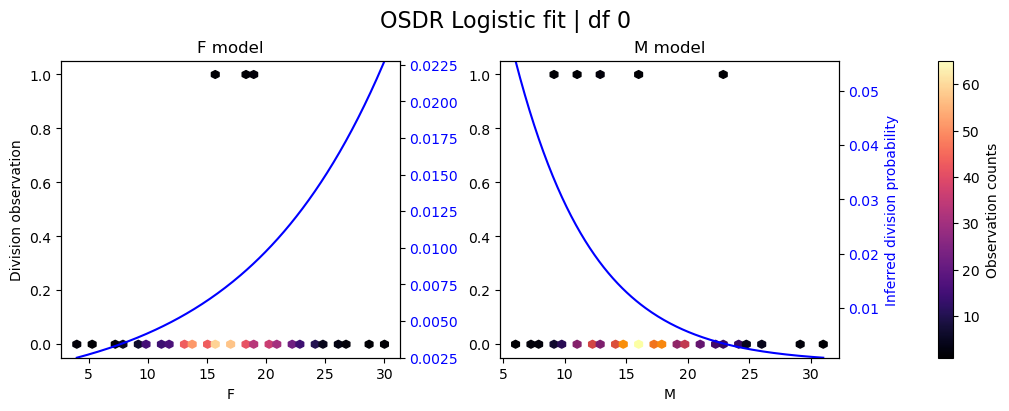

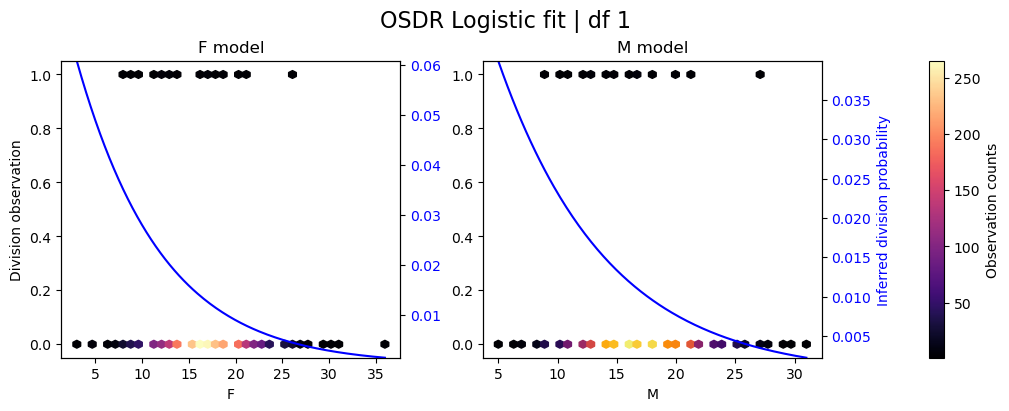

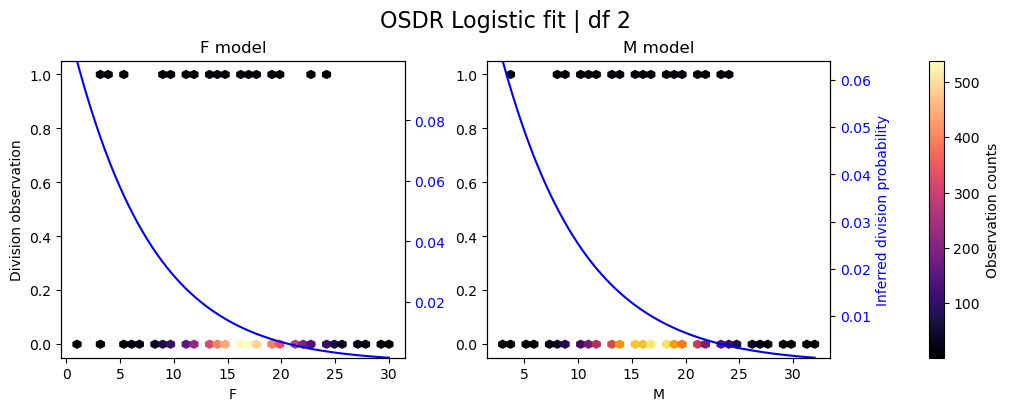

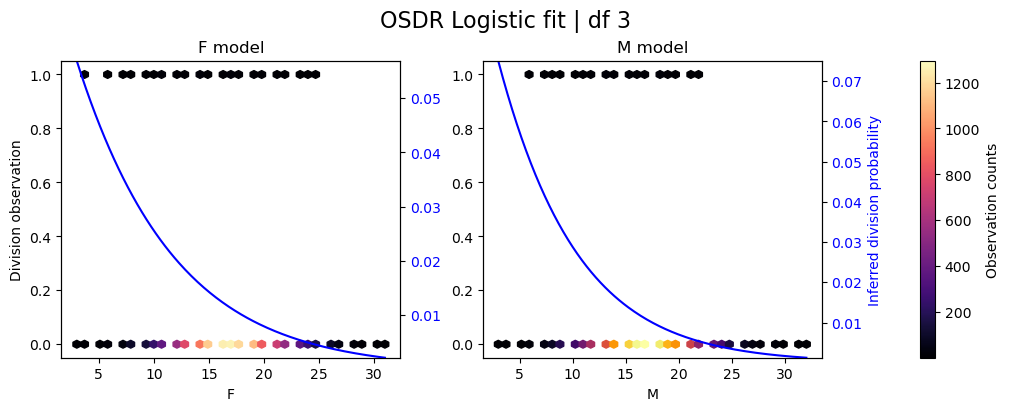

In [62]:
#load samples
main_sample, k1_df, k5_df, k10_df, k25_df  = cell_sampler(post_df, 1000, seed=1)
dfs={0:k1_df, 1:k5_df, 2:k10_df, 3:k25_df}

#load inferred parameters
pplus_f, pplus_m, pminus_f, pminus_m = tissue_regression(post_df, 1000, seed=1, broadcast=True)
params={"pplus_f":pplus_f, "pplus_m":pplus_m, "pminus_f":pminus_f, "pminus_m":pminus_m}

#first dataset (with only the final tissue state at t=1000)
for i in range(0,4):
    visualise_logfit(dfs, params, t_id=i)